In [1]:
# # Installing the required libraries
# !pip install SQLAlchemy
# !pip install pandas
# !pip install pymysql
# !pip install pandasql
# !pip install geopandas matplotlib
# !pip install linearmodels

# Load in Data & Libraries

In [2]:
import pandas as pd
import numpy as np
import json
import csv
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_lm
import sklearn
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.image as mpimg
from matplotlib.patches import Patch
import requests
from pandasql import sqldf
import geopandas as gpd
from shapely.geometry import Point, shape
import plotly.express as px
from linearmodels.iv import IV2SLS

In [3]:
# # Note: If you are not going to utilize a MySQL database, comment out this cell

# username = "root" # the username of your database
# password = # the password of your database
# connection_name = "localhost"
# schema = # the name of your schema

# engine = sqlalchemy.create_engine(f"mysql+pymysql://{username}:{password}@{connection_name}/{schema}?charset=utf8mb4", pool_pre_ping=True)
# connection = engine.connect()

In [4]:
# read data into Python

df_dict = {}

## SF Data

# SFDA Prosecutions 2014-2023
sf_prosecutions = pd.read_csv('./SF_Data/District_Attorney_Cases_Prosecuted.csv').drop('id', axis=1)
df_dict["sf_prosecutions"] = sf_prosecutions

# SF Case Resolutions ALL Crimes 2015-2023
sf_cr_a = pd.read_csv('./SF_Data/Case_Resoultions_All_Crimes.csv').drop('id', axis=1)
df_dict["sf_cr_a"] = sf_cr_a

# SF Case Resolutions Violent Crimes ONLY 2015-2023
sf_cr_v = pd.read_csv('./SF_Data/Case_Resoultions_Violent_Crimes.csv').drop('id', axis=1)
df_dict["sf_cr_v"] = sf_cr_v

# SFDA Actions ALL Crimes 2015-2023
sf_act_a = pd.read_csv('./SF_Data/DA_Actions_On_Arrests_All_Crimes.csv').drop('id', axis=1)
df_dict["sf_act_a"] = sf_act_a

# SFDA Actions Violent Crimes ONLY 2015-2023
sf_act_v = pd.read_csv('./SF_Data/DA_Actions_On_Arrests_Violent_Crimes.csv').drop('id', axis=1)
df_dict["sf_act_v"] = sf_act_v

# SFPD Incident Outcomes All Crimes 2015-2023
outcomes = pd.read_csv('./SF_Data/Outcomes_of_SFPD_Incidents_All_Crimes.csv').drop('id', axis=1)
df_dict["outcomes"] = outcomes

## USSC Data

# Federal Offenders by Type of Crime All Crimes 2015-2022
fo_c_a = pd.read_csv('./USSC_Data/Federal_Offenders_by_Type_of_Crime_All_Crimes.csv').drop('id', axis=1)
df_dict["fo_c_a"] = fo_c_a

# Federal Offenders by Type of Crime Violent Crimes ONLY 2015-2022
fo_c_v = pd.read_csv('./USSC_Data/Federal_Offenders_by_Type_of_Crime_Violent_Crimes.csv').drop('id', axis=1)
df_dict["fo_c_v"] = fo_c_v

# Federal Offenders by Type District All Crimes 2015-2022
fo_d_a = pd.read_csv('./USSC_Data/Federal_Offenders_in_Each_District_All_Crimes.csv').drop('id', axis=1)
df_dict["fo_d_a"] = fo_d_a

# Federal Offenders by Type District Violent Crimes Only 2015-2022 
fo_d_v = pd.read_csv('./USSC_Data/Federal_Offenders_in_Each_District_Violent_Crimes.csv').drop('id', axis=1)
df_dict["fo_d_v"] = fo_d_v

In [5]:
# # Note: If you are not going to utilize a MySQL database, comment out this cell

# # import the data into database
# for key in df_dict.keys():
#     df = df_dict[key]
#     df.to_sql(key, con = engine, if_exists = 'append')

# Helper Functions

In [6]:
def string_to_number_formatter(string, problematic_chars = [',']):
    string = str(string)
    for char in problematic_chars:
        string = string.replace(char, '')
    
    return int(string)

def difference_creator(arr, num_lags = 1, mode = 'raw', ascending = True):
    result = []
    i = 0
    if ascending == True:
        while i < len(arr):
            j = i - num_lags
            if j < 0:
                diff = 0
            else:
                diff = arr[i] - arr[j]
                if mode == 'pct':
                    diff = 100*(diff / arr[j])
            result += [diff]
            i += 1    
    
    else:
        while i < len(arr):
            j = i + num_lags
            if j >= len(arr):
                diff = 0
            else:
                diff = arr[i] - arr[j]
                if mode == 'pct':
                    diff = 100*(diff / arr[j])
            result += [diff]
            i += 1
    
    return result

# Data Formating

In [7]:
date_format = "%Y/%m/%d"

sf_prosecutions['arrest_date'] = pd.to_datetime(sf_prosecutions['arrest_date'], format = date_format)
sf_prosecutions['data_as_of'] = pd.to_datetime(sf_prosecutions['data_as_of'], format = date_format)

date_format = "%m/%d/%Y %I:%M:%S %p"

sf_prosecutions['data_loaded_at'] = pd.to_datetime(sf_prosecutions['data_loaded_at'], format = date_format)

In [8]:
boudin_start_date = datetime(2020, 1, 8, 0, 0, 0)
boudin_end_date = datetime(2022, 7, 9, 0, 0, 0)
sf_prosecutions_boudin = sf_prosecutions[(sf_prosecutions["arrest_date"] >= boudin_start_date) &
                                         (sf_prosecutions["arrest_date"] < boudin_end_date)]

sf_prosecutions_boudin.head()

,incident_number,court_number,arrest_date,list_of_filed_charges,filed_case_type,crime_type,dv_case,da_action_taken,case_status,data_as_of,data_loaded_at
9383,Z20171107-02506152,2506152,2020-01-09,470D/F/0,MTR,"Forgery, Checks, Access Cards",No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
9384,Z20200115-02520522,2520522,2020-01-30,"487C/F/0, 245A4/M/0",MTR,Theft,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
9385,140153084,14005420,2020-01-14,"591.5/M/0, 273.5A/F/0, 273.5A/F/0, 273.5A/F/0,...",MTR,Assault,Yes,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
9386,150735638,15018930,2020-01-22,"242/M/0, 245A4/F/0, 243B/M/0, 211/F/2",MTR,Robbery,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
9387,150025953,15026261,2020-01-16,"23123A/I/0, 11377/M/0, 11378/F/0",MTR,Narcotics,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56


In [9]:
# Federal Offender Yearly Totals All Crimes 2015 - 2022
fo_t_a = fo_d_a[fo_d_a["District"] == "Total"].reset_index(drop=True)
fo_t_a = fo_t_a.iloc[:, 2:5].drop("Pct", axis = 1)

#Renames the column to be consistent with future dfs
fo_t_a.rename(columns={'Fiscal_Year': 'Year'}, inplace=True)
fo_t_a.rename(columns={'N': 'Total'}, inplace=True)

fo_t_a = fo_t_a.sort_values('Year', ascending = True).reset_index(drop=True)
fo_t_a['Total'] = fo_t_a['Total'].apply(lambda row : string_to_number_formatter(row))
fo_t_a['Log_Total'] = np.log(fo_t_a['Total'])
fo_t_a['Yearly_Change'] = difference_creator(fo_t_a['Total'])
fo_t_a['Yearly_Pct_Change'] = difference_creator(fo_t_a['Total'], mode = 'pct')

fo_t_a['Boudin'] = ((fo_t_a['Year'] >= 2020) & (fo_t_a['Year'] <= 2022)).astype(int)
fo_t_a['SF'] = 0
fo_t_a['Covid_1'] = (fo_t_a['Year'] >= 2020).astype(int)
fo_t_a['Covid_2'] = ((fo_t_a['Year'] >= 2020) & (fo_t_a['Year'] <= 2021)).astype(int)

desired_order = ['Year', 'Total', 'Log_Total', 'Yearly_Change',
                 'Yearly_Pct_Change', 'Covid_1', 'Covid_2', 'SF', 'Boudin'] 
fo_t_a = fo_t_a[desired_order]
fo_t_a

# Federal Offender Yearly Totals Violent Crimes ONLY 2015 - 2022
fo_t_v = fo_d_v[fo_d_v["District"] == "Total"].reset_index(drop=True)
fo_t_v = fo_t_v.iloc[:, 2:5].drop("Pct", axis = 1)

#Renames the column to be consistent with future dfs
fo_t_v.rename(columns={'Fiscal_Year': 'Year'}, inplace=True)
fo_t_v.rename(columns={'N': 'Total'}, inplace=True)

fo_t_v = fo_t_v.sort_values('Year', ascending = True).reset_index(drop=True)
fo_t_v['Total'] = fo_t_v['Total'].apply(lambda row : string_to_number_formatter(row))
fo_t_v['Log_Total'] = np.log(fo_t_v['Total'])
fo_t_v['Yearly_Change'] = difference_creator(fo_t_v['Total'])
fo_t_v['Yearly_Pct_Change'] = difference_creator(fo_t_v['Total'], mode = 'pct')
fo_t_v['Boudin'] = ((fo_t_a['Year'] >= 2020) & (fo_t_a['Year'] <= 2022)).astype(int)
fo_t_v['SF'] = 0
fo_t_v['Covid_1'] = (fo_t_v['Year'] >= 2020).astype(int)
fo_t_v['Covid_2'] = ((fo_t_v['Year'] >= 2020) & (fo_t_v['Year'] <= 2021)).astype(int)

fo_t_v = fo_t_v[desired_order]

In [10]:
# SFDA Conviction Totals All Crimes 2015 - 2022

# This temporarily disables warnings; A warning of a depreciated opperation displayed
warnings.filterwarnings('ignore')

sf_convictions_a = sf_cr_a[["Year", "Conviction"]]
sf_convictions_a = sf_convictions_a[~sf_convictions_a["Year"].isin(['2023*', '2023'])]
sf_convictions_a["Conviction"] = sf_convictions_a["Conviction"].astype(int)
sf_convictions_a["Year"] = sf_convictions_a["Year"].astype(int)
sf_convictions_a = sf_convictions_a.sort_values('Year', ascending = True).reset_index(drop=True)

#Renames the column to be consistent with future dfs
sf_convictions_a.rename(columns={'Conviction': 'Total'}, inplace=True)

sf_convictions_a['Log_Total'] = np.log(sf_convictions_a['Total'])
sf_convictions_a['Yearly_Change'] = difference_creator(sf_convictions_a['Total'])
sf_convictions_a['Yearly_Pct_Change'] = difference_creator(sf_convictions_a['Total'], mode = 'pct')
sf_convictions_a['Boudin'] = ((sf_convictions_a['Year'] >= 2020) & (sf_convictions_a['Year'] <= 2022)).astype(int)
sf_convictions_a['SF'] = 1
sf_convictions_a['Covid_1'] = (sf_convictions_a['Year'] >= 2020).astype(int)
sf_convictions_a['Covid_2'] = ((sf_convictions_a['Year'] >= 2020) & (sf_convictions_a['Year'] <= 2021)).astype(int)

sf_convictions_a = sf_convictions_a[desired_order]

# Reasoning for sf_convictions_a_05
# Chesa Boudin was recalled in the middle of 2022
# So to reflect the fact that he was not in office for the 
# full year, we set the binary variable to be 0.5. This method
# was applied in a similar contex in a 2017 Deschenes et al. paper

sf_convictions_a_05 = sf_convictions_a.copy() #Creates defensive copy
sf_convictions_a_05.at[7, "Boudin"] = 0.5

# SFDA Conviction Totals Violent Crimes ONLY 2015 - 2022

sf_convictions_v = sf_cr_v[["Year", "Conviction"]]
sf_convictions_v = sf_convictions_v[~sf_convictions_v["Year"].isin(['2023*', '2023'])]
sf_convictions_v["Conviction"] = sf_convictions_v["Conviction"].astype(int)
sf_convictions_v["Year"] = sf_convictions_v["Year"].astype(int)
sf_convictions_v = sf_convictions_v.sort_values('Year', ascending = True).reset_index(drop=True)

#Renames the column to be consistent with future dfs
sf_convictions_v.rename(columns={'Conviction': 'Total'}, inplace=True)

sf_convictions_v['Log_Total'] = np.log(sf_convictions_v['Total'])
sf_convictions_v['Yearly_Change'] = difference_creator(sf_convictions_v['Total'])
sf_convictions_v['Yearly_Pct_Change'] = difference_creator(sf_convictions_v['Total'], mode = 'pct')
sf_convictions_v['Boudin'] = ((sf_convictions_v['Year'] >= 2020) & (sf_convictions_v['Year'] <= 2022)).astype(int)
sf_convictions_v['SF'] = 1
sf_convictions_v['Covid_1'] = (sf_convictions_v['Year'] >= 2020).astype(int)
sf_convictions_v['Covid_2'] = ((sf_convictions_v['Year'] >= 2020) & (sf_convictions_v['Year'] <= 2021)).astype(int)

sf_convictions_v = sf_convictions_v[desired_order]

sf_convictions_v_05 = sf_convictions_v.copy() #Creates defensive copy
sf_convictions_v_05.at[7, "Boudin"] = 0.5

# This resets warnings
warnings.resetwarnings()

display(sf_convictions_a_05, sf_convictions_v_05)

,Year,Total,Log_Total,Yearly_Change,Yearly_Pct_Change,Covid_1,Covid_2,SF,Boudin
0,2015,3460,8.149024,0,0.000000,0,0,1,0.0
1,2016,3482,8.155362,22,0.635838,0,0,1,0.0
2,2017,2858,7.957877,-624,-17.920735,0,0,1,0.0
3,2018,3327,8.109826,469,16.410077,0,0,1,0.0
4,2019,3632,8.197539,305,9.167418,0,0,1,0.0
5,2020,1976,7.588830,-1656,-45.594714,1,1,1,1.0
6,2021,1258,7.137278,-718,-36.336032,1,1,1,1.0
7,2022,1397,7.242082,139,11.049285,1,0,1,0.5


,Year,Total,Log_Total,Yearly_Change,Yearly_Pct_Change,Covid_1,Covid_2,SF,Boudin
0,2015,1039,6.946014,0,0.000000,0,0,1,0.0
1,2016,972,6.879356,-67,-6.448508,0,0,1,0.0
2,2017,860,6.756932,-112,-11.522634,0,0,1,0.0
3,2018,995,6.902743,135,15.697674,0,0,1,0.0
4,2019,1088,6.992096,93,9.346734,0,0,1,0.0
5,2020,635,6.453625,-453,-41.636029,1,1,1,1.0
6,2021,438,6.082219,-197,-31.023622,1,1,1,1.0
7,2022,494,6.202536,56,12.785388,1,0,1,0.5


In [11]:
warnings.filterwarnings('ignore')

# Federal Offender & SF Yearly Totals All Crimes 2015 - 2022
fs_t_a = pd.concat([fo_t_a, sf_convictions_a], axis=0).reset_index(drop=True)
fs_t_a["Violent"] = 0

# Federal Offender & SF Yearly (w/ 0.5) Totals All Crimes 2015 - 2022
fs_t_a_05 = pd.concat([fo_t_a, sf_convictions_a_05], axis=0).reset_index(drop=True)
fs_t_a_05["Violent"] = 0

# Federal Offender & SF Yearly Totals Violent Crimes ONLY 2015 - 2022
fs_t_v = pd.concat([fo_t_v, sf_convictions_v], axis=0).reset_index(drop=True)
fs_t_v["Violent"] = 1

# Federal Offender & SF Yearly (w/ 0.5) Totals Violent Crimes ONLY 2015 - 2022
fs_t_v_05 = pd.concat([fo_t_v, sf_convictions_v_05], axis=0).reset_index(drop=True)
fs_t_v_05["Violent"] = 1

# fs_t_a & fs_t_v Combined
fs_t_master = pd.concat([fs_t_a, fs_t_v], axis=0).reset_index(drop=True)
fs_t_master['Boudin_SF'] = fs_t_master['Boudin'] * fs_t_master['SF']

# fs_t_a_05 & fs_t_v_05 Combined
fs_t_master_05 = pd.concat([fs_t_a_05, fs_t_v_05], axis=0).reset_index(drop=True)
fs_t_master_05['Boudin_SF'] = fs_t_master_05['Boudin'] * fs_t_master_05['SF']

fs_t_a = fs_t_a[desired_order]
fs_t_a_05 = fs_t_a_05[desired_order]
fs_t_v = fs_t_v[desired_order]
fs_t_v_05 = fs_t_v_05[desired_order]

fs_t_a['Boudin_SF'] = fs_t_a['Boudin'] * fs_t_a['SF'] 
fs_t_a_05['Boudin_SF'] = fs_t_a_05['Boudin'] * fs_t_a_05['SF']
fs_t_v['Boudin_SF'] = fs_t_v['Boudin'] * fs_t_v['SF']
fs_t_v_05['Boudin_SF'] = fs_t_v_05['Boudin'] * fs_t_v_05['SF']

warnings.resetwarnings()

# Data Analysis

## Stage I - US v. SF

### Model

$Y_{r,t} = \beta_0 + \beta_1 1(D_t \times SF_r) + \beta_2 (SF_r) + \pi_{r,t} + \epsilon_{r,t}$
- $Y_{r,t} \text{ = Dependent Variable in region r during year t}$
- $\text{D = Binary Indicator for whether Chesa Boudin was in office during year t}$
- $SF_r \text{ = Binary Indicator for San Francisco (Location Fixed Effect)}$
- $\pi_{m, t} \text{ = COVID Pandemic Fixed-Effect; Either } COVID_1 \text{ or } COVID_2$
- $COVID_1 \text{ = COVID using simple cuttoff at the start of the CA Shelter-In-Place-Orders, March 2020}$
- $COVID_2 \text{ = COVID using a range from March 2020 to the end of 2021, when the virus became endemic}$

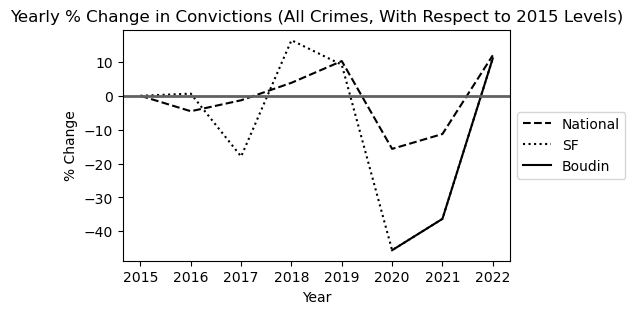

In [12]:
# Extract data for plotting
df_sf0_violent0 = fs_t_master[(fs_t_master['SF'] == 0) & (fs_t_master['Violent'] == 0)]
df_sf0_violent1 = fs_t_master[(fs_t_master['SF'] == 0) & (fs_t_master['Violent'] == 1)]
df_sf1_violent0 = fs_t_master[(fs_t_master['SF'] == 1) & (fs_t_master['Violent'] == 0)]
df_sf1_violent1 = fs_t_master[(fs_t_master['SF'] == 1) & (fs_t_master['Violent'] == 1)]
df_boudin_violent0 = fs_t_master[(fs_t_master['Boudin_SF'] == 1) & (fs_t_master['Violent'] == 0)]
df_boudin_violent1 = fs_t_master[(fs_t_master['Boudin_SF'] == 1) & (fs_t_master['Violent'] == 1)]

# Plotting the lines
plt.figure(figsize=(5, 3))
plt.plot(df_sf0_violent0['Year'], df_sf0_violent0['Yearly_Pct_Change'], 
         color = 'black', linestyle='dashed', label='National')
plt.plot(df_sf1_violent0['Year'], df_sf1_violent0['Yearly_Pct_Change'], 
         color = 'black', linestyle='dotted', label='SF')
plt.plot(df_boudin_violent0['Year'], df_boudin_violent0['Yearly_Pct_Change'], 
         color = 'black', linestyle='solid', label='Boudin')

# Adding a horizontal line at y=0
plt.axhline(y=0, color='#616161', linewidth=2)

# Adding labels and legend
plt.title('Yearly % Change in Convictions (All Crimes, With Respect to 2015 Levels)')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

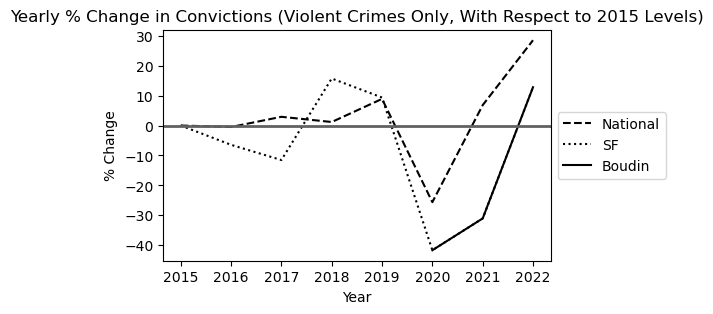

In [13]:
# Plotting the lines
plt.figure(figsize=(5, 3))
plt.plot(df_sf0_violent1['Year'], df_sf0_violent1['Yearly_Pct_Change'], 
         color = 'black', linestyle='dashed', label='National')
plt.plot(df_sf1_violent1['Year'], df_sf1_violent1['Yearly_Pct_Change'], 
         color = 'black', linestyle='dotted', label='SF')
plt.plot(df_boudin_violent1['Year'], df_boudin_violent1['Yearly_Pct_Change'], 
         color = 'black', linestyle='solid', label='Boudin')

# Adding a horizontal line at y=0
plt.axhline(y=0, color='#616161', linewidth=2)

# Adding labels and legend
plt.title('Yearly % Change in Convictions (Violent Crimes Only, With Respect to 2015 Levels)')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

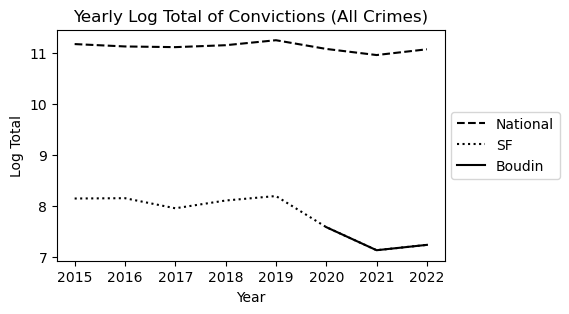

In [14]:
# Plotting the lines
plt.figure(figsize=(5, 3))
plt.plot(df_sf0_violent0['Year'], df_sf0_violent0['Log_Total'], 
         color = 'black', linestyle='dashed', label='National')
plt.plot(df_sf1_violent0['Year'], df_sf1_violent0['Log_Total'], 
         color = 'black', linestyle='dotted', label='SF')
plt.plot(df_boudin_violent0['Year'], df_boudin_violent0['Log_Total'], 
         color = 'black', linestyle='solid', label='Boudin')

# Adding labels and legend
plt.title('Yearly Log Total of Convictions (All Crimes)')
plt.xlabel('Year')
plt.ylabel('Log Total')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

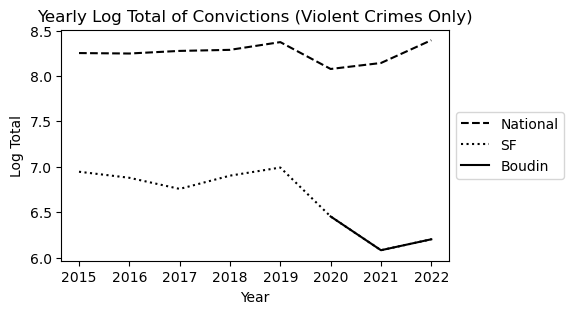

In [15]:
# Plotting the lines
plt.figure(figsize=(5, 3))
plt.plot(df_sf0_violent1['Year'], df_sf0_violent1['Log_Total'], 
         color = 'black', linestyle='dashed', label='National')
plt.plot(df_sf1_violent1['Year'], df_sf1_violent1['Log_Total'], 
         color = 'black', linestyle='dotted', label='SF')
plt.plot(df_boudin_violent1['Year'], df_boudin_violent1['Log_Total'], 
         color = 'black', linestyle='solid', label='Boudin')

# Adding labels and legend
plt.title('Yearly Log Total of Convictions (Violent Crimes Only)')
plt.xlabel('Year')
plt.ylabel('Log Total')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(False)
plt.show()

### Log_Total: Boudin(t = 2022) == 1

### Using Covid_1

In [16]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_a)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.996
Model:                            GLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2068.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.52e-16
Time:                        14:58:39   Log-Likelihood:                 13.823
No. Observations:                  16   AIC:                            -19.65
Df Residuals:                      12   BIC:                            -16.56
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1602      0.021    523.221      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.985
Model:                            GLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     508.7
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           6.59e-13
Time:                        14:58:39   Log-Likelihood:                 13.690
No. Observations:                  16   AIC:                            -19.38
Df Residuals:                      12   BIC:                            -16.29
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2868      0.020    409.143      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### Using Covid_2

In [18]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_a)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.996
Model:                            GLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1786.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           3.65e-16
Time:                        14:58:39   Log-Likelihood:                 12.740
No. Observations:                  16   AIC:                            -17.48
Df Residuals:                      12   BIC:                            -14.39
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1258      0.027    407.536      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [19]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.986
Model:                            GLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     440.6
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.55e-12
Time:                        14:58:39   Log-Likelihood:                 14.472
No. Observations:                  16   AIC:                            -20.94
Df Residuals:                      12   BIC:                            -17.85
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2846      0.027    305.630      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Log_Total: Boudin(t = 2022) == 0.5

#### Using Covid_1

In [20]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_a_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.993
Model:                            GLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1287.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           2.59e-15
Time:                        14:58:39   Log-Likelihood:                 9.1073
No. Observations:                  16   AIC:                            -10.21
Df Residuals:                      12   BIC:                            -7.124
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1933      0.036    309.085      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_v_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.977
Model:                            GLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     264.8
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           3.17e-11
Time:                        14:58:39   Log-Likelihood:                 10.454
No. Observations:                  16   AIC:                            -12.91
Df Residuals:                      12   BIC:                            -9.817
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3127      0.031    272.209      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### Using Covid_2

In [22]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_a_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.991
Model:                            GLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1352.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.93e-15
Time:                        14:58:39   Log-Likelihood:                 6.8840
No. Observations:                  16   AIC:                            -5.768
Df Residuals:                      12   BIC:                            -2.678
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1102      0.037    299.104      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [23]:
np.random.seed(29)
formula = "Log_Total ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_v_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              Log_Total   R-squared:                       0.974
Model:                            GLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     344.5
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           6.68e-12
Time:                        14:58:39   Log-Likelihood:                 9.3397
No. Observations:                  16   AIC:                            -10.68
Df Residuals:                      12   BIC:                            -7.589
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2750      0.034    242.603      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Yearly_Pct_Change: Boudin(t = 2022) == 1

### Using Covid_1

In [24]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_a)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.324
Model:                            GLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     1.251
Date:                Thu, 25 Jan 2024   Prob (F-statistic):              0.335
Time:                        14:58:39   Log-Likelihood:                -64.777
No. Observations:                  16   AIC:                             137.6
Df Residuals:                      12   BIC:                             140.6
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6441      2.271      0.724      0.4

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [25]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_v)
result = model.fit(cov_type='HC0')
print(result.summary())

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.246
Model:                            GLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                    0.9093
Date:                Thu, 25 Jan 2024   Prob (F-statistic):              0.465
Time:                        14:58:39   Log-Likelihood:                -66.254
No. Observations:                  16   AIC:                             140.5
Df Residuals:                      12   BIC:                             143.6
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4939      1.522      1.638      0.1

#### Using Covid_2

In [26]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_a)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.670
Model:                            GLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     13.79
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           0.000340
Time:                        14:58:39   Log-Likelihood:                -59.040
No. Observations:                  16   AIC:                             126.1
Df Residuals:                      12   BIC:                             129.2
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0691      2.866      2.117      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.552
Model:                            GLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     7.780
Date:                Thu, 25 Jan 2024   Prob (F-statistic):            0.00378
Time:                        14:58:39   Log-Likelihood:                -62.089
No. Observations:                  16   AIC:                             132.2
Df Residuals:                      12   BIC:                             135.3
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3549      4.261      2.195      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Yearly_Pct_Change: Boudin(t = 2022) == 0.5

#### Using Covid_1

In [28]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_a_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.526
Model:                            GLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     8.034
Date:                Thu, 25 Jan 2024   Prob (F-statistic):            0.00334
Time:                        14:58:39   Log-Likelihood:                -61.940
No. Observations:                  16   AIC:                             131.9
Df Residuals:                      12   BIC:                             135.0
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9564      3.184     -0.300      0.7

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [29]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_1"
model = smf.gls(formula=formula, data=fs_t_v_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.435
Model:                            GLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     7.152
Date:                Thu, 25 Jan 2024   Prob (F-statistic):            0.00519
Time:                        14:58:39   Log-Likelihood:                -63.950
No. Observations:                  16   AIC:                             135.9
Df Residuals:                      12   BIC:                             139.0
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2105      2.545      0.083      0.9

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### Using Covid_2

In [30]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_a_05)
result = model.fit(cov_type='HC0')
print(result.summary())

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.714
Model:                            GLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     27.16
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.24e-05
Time:                        14:58:39   Log-Likelihood:                -57.891
No. Observations:                  16   AIC:                             123.8
Df Residuals:                      12   BIC:                             126.9
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7473      2.663      1.783      0.0

In [31]:
np.random.seed(29)
formula = "Yearly_Pct_Change ~ Boudin_SF + SF + Covid_2"
model = smf.gls(formula=formula, data=fs_t_v_05)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:      Yearly_Pct_Change   R-squared:                       0.579
Model:                            GLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     13.78
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           0.000342
Time:                        14:58:39   Log-Likelihood:                -61.584
No. Observations:                  16   AIC:                             131.2
Df Residuals:                      12   BIC:                             134.3
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1991      4.208      1.949      0.0

C:\Users\jgte2\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Stage II - SF Before, During, & After Boudin

### Model
$Y_{m, t} = \beta_0 + \beta_1 Boudin_{m, t} + \mu_{m} + \pi_{m, t} + \epsilon_{m, t}$
- $Y_{m,t} \text{ = Dependent Variable in month m during year t}$
- $Boudin_{m, t} \text{ = Binary Indicator for whether Chesa Boudin was in office during month m in year t}$
- $\mu_{m} \text{ = Monthly Fixed-Effects}$
- $\pi_{m, t} \text{ = COVID Pandemic Fixed-Effect; Either } COVID_1 \text{ or } COVID_2$
- $COVID_1 \text{ = COVID using simple cuttoff at the start of the CA Shelter-In-Place-Orders, March 2020}$
- $COVID_2 \text{ = COVID using a range from March 2020 to the end of 2021, when the virus became endemic}$

In [32]:
violent_crimes = ['Assault and Battery', 'Assault', 'Robbery', 'Other Sex Law Violations', 'Weapons', 'Hit-and-Run',
                  'Willful Homicide', 'Willful Homicide (Att.)', 'Kidnapping', 'Arson', 'Forcible Rape', 
                  'Lewd or Lascivious', 'Manslaughter - Non Vehicular', 'Manslaughter - Vehicular', 'Annoy/Molest Children',
                  'Obscene Matter', 'Enhancements']

### This dataframe only keeps values between 2014 & 2023
sfp_rev = sf_prosecutions[(sf_prosecutions["arrest_date"] >= datetime(2014, 1, 1, 0, 0, 0)) & (sf_prosecutions["arrest_date"] < datetime(2024, 1, 1, 0, 0, 0))]
sfp_rev = sfp_rev.reset_index()
sfp_rev_v = sfp_rev[sfp_rev['crime_type'].isin(violent_crimes)].reset_index()
sfp_rev_v

,level_0,index,incident_number,court_number,arrest_date,list_of_filed_charges,filed_case_type,crime_type,dv_case,da_action_taken,case_status,data_as_of,data_loaded_at
0,3,3,130512519,2474189,2014-01-03,242/M/0,MTR,Assault and Battery,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
1,7,7,110038109,11001244,2014-01-16,"594B1/F/0, 136.1C1/F/0, 245A4/F/0, 245A1/F/0, ...",MTR,Assault,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
2,9,9,110086948,11002870,2014-01-23,"211/F/0, 496A/F/0, 32/F/0",MTR,Robbery,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
3,18,18,110206005,11007143,2014-01-27,211/F/2,MTR,Robbery,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
4,19,19,110210802,11007340,2014-01-31,"459/M/2, 242/M/0, 666A/M/0",MTR,Assault and Battery,No,New charges filed,Filed Motion to Revoke,2024-01-08,2024-01-08 22:00:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27386,61861,80349,210552944,21008555,2021-08-28,452C/M/0,Misdemeanor,Arson,No,New charges filed,Successful Diversion,2024-01-08,2024-01-08 22:00:56
27387,61862,80350,220385315,2530926,2022-06-12,452D/M/0,Misdemeanor,Arson,No,New charges filed,Fugitive Status,2024-01-08,2024-01-08 22:00:56
27388,70227,91972,Z20170728-02504384,2504384,2017-07-28,311.11A/M/0,Misdemeanor,Obscene Matter,No,New charges filed,NaN,2024-01-08,2024-01-08 22:00:56
27389,70228,91973,Z20170831-02504972,2504972,2017-08-31,"311.1A/M/0, 311.1A/M/0",Misdemeanor,Obscene Matter,No,New charges filed,NaN,2024-01-08,2024-01-08 22:00:56


In [33]:
sfp_rev['arrest_yr'] = sfp_rev['arrest_date'].dt.year
sfp_rev['arrest_month'] = sfp_rev['arrest_date'].dt.month

sfp_rev_v['arrest_yr'] = sfp_rev_v['arrest_date'].dt.year
sfp_rev_v['arrest_month'] = sfp_rev_v['arrest_date'].dt.month

In [34]:
sfp_rev.groupby(['arrest_yr', 'arrest_month', 'case_status', 'crime_type']).size().reset_index(name='count')

sfp_rev_v.groupby(['arrest_yr', 'arrest_month', 'case_status', 'crime_type']).size().reset_index(name='count')

,arrest_yr,arrest_month,case_status,crime_type,count
0,2014,1,Conviction,Annoy/Molest Children,1
1,2014,1,Conviction,Arson,2
2,2014,1,Conviction,Assault,28
3,2014,1,Conviction,Assault and Battery,19
4,2014,1,Conviction,Hit-and-Run,1
...,...,...,...,...,...
5074,2023,12,Pending,Other Sex Law Violations,2
5075,2023,12,Pending,Robbery,24
5076,2023,12,Pending,Weapons,31
5077,2023,12,Pending,Willful Homicide,2


In [35]:
# Group by year, month, and action_type, then calculate counts
case_status_counts = sfp_rev.groupby(['arrest_yr', 'arrest_month', 'case_status']).size().reset_index(name='count')

# Group by year, month, and crime_type, then calculate counts
crime_type_counts = sfp_rev.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')

# Group by year, month, and action_type, then calculate counts
case_status_counts_v = sfp_rev_v.groupby(['arrest_yr', 'arrest_month', 'case_status']).size().reset_index(name='count')

# Group by year, month, and crime_type, then calculate counts
crime_type_counts_v = sfp_rev_v.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')

In [36]:
case_status_pivot = case_status_counts.pivot(index=['arrest_yr', 'arrest_month'], columns='case_status', values='count').reset_index()
case_status_pivot = case_status_pivot.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)

crime_type_pivot = crime_type_counts.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
crime_type_pivot = crime_type_pivot.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)

case_status_pivot_v = case_status_counts_v.pivot(index=['arrest_yr', 'arrest_month'], columns='case_status', values='count').reset_index()
case_status_pivot_v = case_status_pivot_v.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)

crime_type_pivot_v = crime_type_counts_v.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
crime_type_pivot_v = crime_type_pivot_v.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)

In [37]:
case_status_pivot['Log_Conviction'] = np.log(case_status_pivot['Conviction'])
case_status_pivot_v['Log_Conviction'] = np.log(case_status_pivot_v['Conviction'])
case_status_pivot['Log_Successful_Diversion'] = np.log(case_status_pivot['Successful Diversion'])
case_status_pivot_v['Log_Successful_Diversion'] = np.log(case_status_pivot_v['Successful Diversion'])
case_status_pivot['arrest_month_str'] = case_status_pivot['arrest_month'].astype(str)
case_status_pivot_v['arrest_month_str'] = case_status_pivot_v['arrest_month'].astype(str)

C:\Users\jgte2\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
prosecutions = sfp_rev.groupby(['arrest_yr', 'arrest_month', 'da_action_taken']).size().reset_index(name='Prosecutions')
prosecutions = prosecutions[prosecutions['da_action_taken'] == 'New charges filed']
prosecutions['Log_Prosecutions'] = np.log(prosecutions['Prosecutions'])

prosecutions_v = sfp_rev_v.groupby(['arrest_yr', 'arrest_month', 'da_action_taken']).size().reset_index(name='Prosecutions')
prosecutions_v = prosecutions_v[prosecutions_v['da_action_taken'] == 'New charges filed']
prosecutions_v['Log_Prosecutions'] = np.log(prosecutions_v['Prosecutions'])

In [39]:
prosecutions

,arrest_yr,arrest_month,da_action_taken,Prosecutions,Log_Prosecutions
0,2014,1,New charges filed,777,6.655440
2,2014,2,New charges filed,693,6.541030
4,2014,3,New charges filed,762,6.635947
6,2014,4,New charges filed,754,6.625392
8,2014,5,New charges filed,768,6.643790
...,...,...,...,...,...
230,2023,8,New charges filed,508,6.230481
232,2023,9,New charges filed,532,6.276643
234,2023,10,New charges filed,555,6.318968
236,2023,11,New charges filed,544,6.298949


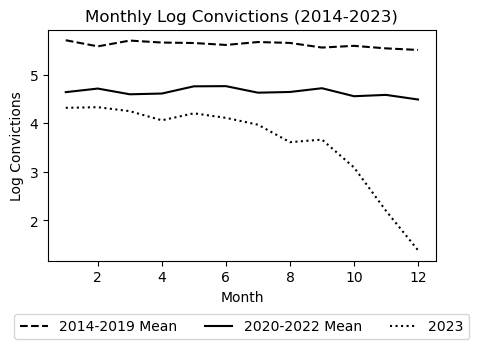

In [40]:
df = case_status_pivot
column_of_interest = 'Log_Conviction'

df_2014_2019 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2019)]
df_2020_2022 = df[(df['arrest_yr'] >= 2020) & (df['arrest_yr'] <= 2022)]
df_2023 = df[df['arrest_yr'] == 2023]

monthly_avg_2014_2019 = df_2014_2019.groupby(['arrest_month']).mean()[column_of_interest]
monthly_avg_2020_2022 = df_2020_2022.groupby(['arrest_month']).mean()[column_of_interest]
monthly_values_2023 = df_2023[column_of_interest]

plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2019 Avg': monthly_avg_2014_2019.values,
    '2020-2022 Avg': monthly_avg_2020_2022.values,
    '2023 Values': monthly_values_2023.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2019 Avg', data=plot_data, label='2014-2019 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2020-2022 Avg', data=plot_data, label='2020-2022 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2023 Values', data=plot_data, label='2023', color='black', linestyle = 'dotted')

label = f'{column_of_interest}s'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2023)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# img = mpimg.imread('./SFDA-logo.png')
# ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto', zorder=-1)
plt.show()

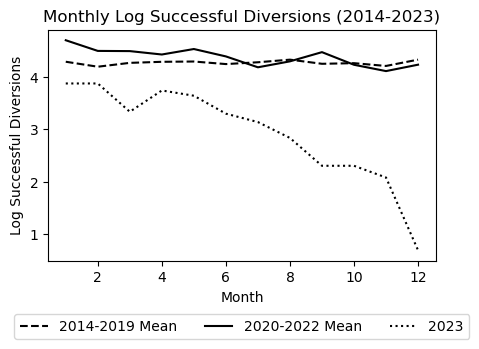

In [41]:
df = case_status_pivot
column_of_interest = 'Log_Successful_Diversion'

df_2014_2019 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2019)]
df_2020_2022 = df[(df['arrest_yr'] >= 2020) & (df['arrest_yr'] <= 2022)]
df_2023 = df[df['arrest_yr'] == 2023]

monthly_avg_2014_2019 = df_2014_2019.groupby(['arrest_month']).mean()[column_of_interest]
monthly_avg_2020_2022 = df_2020_2022.groupby(['arrest_month']).mean()[column_of_interest]
monthly_values_2023 = df_2023[column_of_interest]

plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2019 Avg': monthly_avg_2014_2019.values,
    '2020-2022 Avg': monthly_avg_2020_2022.values,
    '2023 Values': monthly_values_2023.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2019 Avg', data=plot_data, label='2014-2019 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2020-2022 Avg', data=plot_data, label='2020-2022 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2023 Values', data=plot_data, label='2023', color='black', linestyle = 'dotted')

label = f'{column_of_interest}s'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2023)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# img = mpimg.imread('./SFDA-logo.png')
# ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto', zorder=-1)
plt.show()

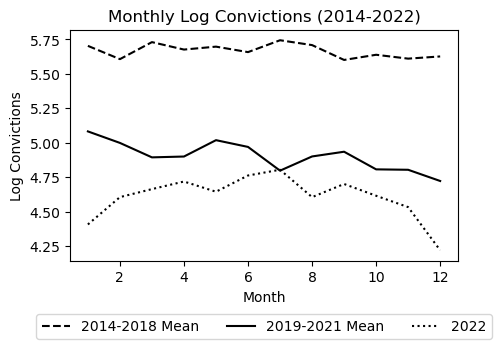

In [42]:
df = case_status_pivot
column_of_interest = 'Log_Conviction'

df_2014_2018 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2018)]
df_2019_2021 = df[(df['arrest_yr'] >= 2019) & (df['arrest_yr'] <= 2021)]
df_2022 = df[df['arrest_yr'] == 2022]

monthly_avg_2014_2018 = df_2014_2018.groupby(['arrest_month']).mean()[column_of_interest]
monthly_avg_2019_2021 = df_2019_2021.groupby(['arrest_month']).mean()[column_of_interest]
monthly_values_2022 = df_2022[column_of_interest]

plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2018 Avg': monthly_avg_2014_2018.values,
    '2019-2021 Avg': monthly_avg_2019_2021.values,
    '2022 Values': monthly_values_2022.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2018 Avg', data=plot_data, label='2014-2018 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2019-2021 Avg', data=plot_data, label='2019-2021 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2022 Values', data=plot_data, label='2022', color='black', linestyle = 'dotted')

label = f'{column_of_interest}s'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2022)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# img = mpimg.imread('./SFDA-logo.png')
# ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto', zorder=-1)
plt.show()

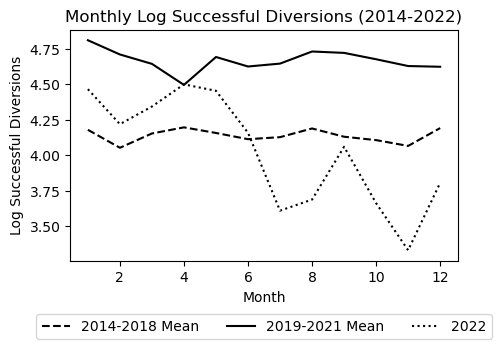

In [43]:
df = case_status_pivot
column_of_interest = 'Log_Successful_Diversion'

df_2014_2018 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2018)]
df_2019_2021 = df[(df['arrest_yr'] >= 2019) & (df['arrest_yr'] <= 2021)]
df_2022 = df[df['arrest_yr'] == 2022]

monthly_avg_2014_2018 = df_2014_2018.groupby(['arrest_month']).mean()[column_of_interest]
monthly_avg_2019_2021 = df_2019_2021.groupby(['arrest_month']).mean()[column_of_interest]
monthly_values_2022 = df_2022[column_of_interest]

plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2018 Avg': monthly_avg_2014_2018.values,
    '2019-2021 Avg': monthly_avg_2019_2021.values,
    '2022 Values': monthly_values_2022.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2018 Avg', data=plot_data, label='2014-2018 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2019-2021 Avg', data=plot_data, label='2019-2021 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2022 Values', data=plot_data, label='2022', color='black', linestyle = 'dotted')

label = f'{column_of_interest}s'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2022)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# img = mpimg.imread('./SFDA-logo.png')
# ax.imshow(img, extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], aspect='auto', zorder=-1)
plt.show()

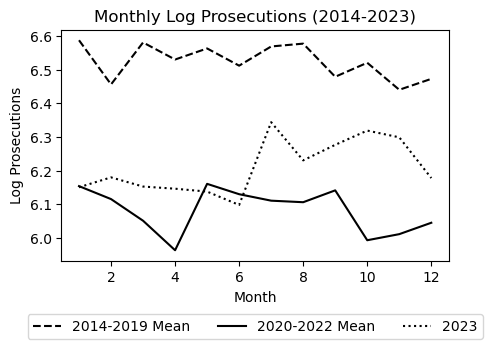

In [115]:
df = prosecutions
column_of_interest = 'Log_Prosecutions'

df_2014_2019 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2019)]
df_2020_2022 = df[(df['arrest_yr'] >= 2020) & (df['arrest_yr'] <= 2022)]
df_2023 = df[df['arrest_yr'] == 2023]

monthly_avg_2014_2019 = df_2014_2019.groupby(['arrest_month']).agg({column_of_interest : np.mean}).iloc[:, 0] # .iloc turns it into series
monthly_avg_2020_2022 = df_2020_2022.groupby(['arrest_month']).agg({column_of_interest : np.mean}).iloc[:, 0] # .iloc turns it into series
monthly_values_2023 = df_2023[column_of_interest]

plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2019 Avg': monthly_avg_2014_2019.values,
    '2020-2022 Avg': monthly_avg_2020_2022.values,
    '2023 Values': monthly_values_2023.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2019 Avg', data=plot_data, label='2014-2019 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2020-2022 Avg', data=plot_data, label='2020-2022 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2023 Values', data=plot_data, label='2023', color='black', linestyle = 'dotted')

label = f'{column_of_interest}'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2023)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.show()

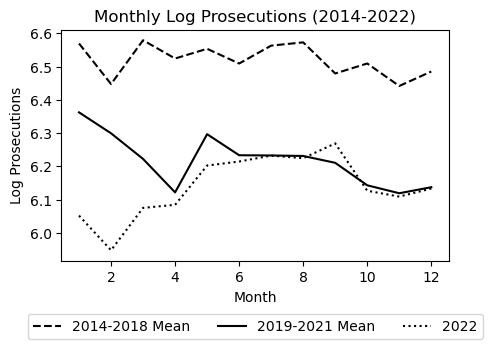

In [45]:
df = prosecutions
column_of_interest = 'Log_Prosecutions'

df_2014_2018 = df[(df['arrest_yr'] >= 2014) & (df['arrest_yr'] <= 2018)]
df_2019_2021 = df[(df['arrest_yr'] >= 2019) & (df['arrest_yr'] <= 2021)]
df_2022 = df[df['arrest_yr'] == 2022]

monthly_avg_2014_2018 = df_2014_2018.groupby(['arrest_month']).agg({column_of_interest : np.mean}).iloc[:, 0] # .iloc turns it into series
monthly_avg_2019_2021 = df_2019_2021.groupby(['arrest_month']).agg({column_of_interest : np.mean}).iloc[:, 0] # .iloc turns it into series
monthly_values_2022 = df_2022[column_of_interest]



plot_data = pd.DataFrame({
    'Month': monthly_avg_2014_2019.index,
    '2014-2018 Avg': monthly_avg_2014_2018.values,
    '2019-2021 Avg': monthly_avg_2019_2021.values,
    '2022 Values': monthly_values_2022.values
})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Month', y='2014-2018 Avg', data=plot_data, label='2014-2018 Mean', color='black', linestyle = 'dashed')
sns.lineplot(x='Month', y='2019-2021 Avg', data=plot_data, label='2019-2021 Mean', color='black', linestyle = 'solid')
ax = sns.lineplot(x='Month', y='2022 Values', data=plot_data, label='2022', color='black', linestyle = 'dotted')

label = f'{column_of_interest}'
label = label.replace("_", " ")
plt.title(f'Monthly {label} (2014-2022)')
plt.xlabel('Month')
plt.ylabel(f'{label}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [46]:
boudin_start_date = datetime(2020, 1, 8, 0, 0, 0)
boudin_end_date = datetime(2022, 7, 9, 0, 0, 0)

# NOTE: arrest_yr & date show when a defendant was arrested, not when they were convicted
# The datset does not show the dates of convictions.
# However, from the SFDA dashboard, we know that the average Median Number of Days from
# Arrest to Conviction for convictions that occured during 2020 to 2022 was approximately 
# 307 days (~10 months) for All Crimes and 426 days (~14 months) for Violent Crimes. See Case_Resolutions 
# csv's for data. To approximate, the number of convictions during the Boudin administration,
# the cutoffs for arrest_yr and month will be lagged. [i.e. The cuttoffs for
# a Boudin conviction for All Crimes will be (arrest_yr: 2019, arrest_month: 3) & 
# (arrest_yr: 2021, arrest_month: 9)]. The same logic applies for the violent crimes.
# For example, while an arrest during January 2022, would have occured during his tenure,
# it is unlikely that a conviction on such a case would have came from his administration.
# While imperfect, this system better accounts for the time passed from arrest to conviction
# than merely setting the cuttoffs at the points that Boudin entered office.

condition_1 = (crime_type_pivot['arrest_yr'] >= 2019) & (crime_type_pivot['arrest_yr'] <= 2021)
condition_2 = (crime_type_pivot['arrest_yr'] == 2019) & (crime_type_pivot['arrest_month'] < 3)
condition_3 = (crime_type_pivot['arrest_yr'] == 2021) & (crime_type_pivot['arrest_month'] > 9)
crime_type_pivot['Boudin'] = 0
crime_type_pivot.loc[condition_1 & ~condition_2 & ~condition_3, 'Boudin'] = 1

condition_1 = (crime_type_pivot['arrest_yr'] >= 2018) & (crime_type_pivot['arrest_yr'] <= 2021)
condition_2 = (crime_type_pivot['arrest_yr'] == 2018) & (crime_type_pivot['arrest_month'] < 11)
condition_3 = (crime_type_pivot['arrest_yr'] == 2021) & (crime_type_pivot['arrest_month'] > 5)
crime_type_pivot_v['Boudin'] = 0
crime_type_pivot_v.loc[condition_1 & ~condition_2 & ~condition_3, 'Boudin'] = 1

condition_1 = (case_status_pivot['arrest_yr'] >= 2019) & (case_status_pivot['arrest_yr'] <= 2021)
condition_2 = (case_status_pivot['arrest_yr'] == 2019) & (case_status_pivot['arrest_month'] < 3)
condition_3 = (case_status_pivot['arrest_yr'] == 2021) & (case_status_pivot['arrest_month'] > 9)
case_status_pivot['Boudin'] = 0
case_status_pivot.loc[condition_1 & ~condition_2 & ~condition_3, 'Boudin'] = 1

condition_1 = (case_status_pivot['arrest_yr'] >= 2018) & (case_status_pivot['arrest_yr'] <= 2021)
condition_2 = (case_status_pivot['arrest_yr'] == 2018) & (case_status_pivot['arrest_month'] < 11)
condition_3 = (case_status_pivot['arrest_yr'] == 2021) & (case_status_pivot['arrest_month'] > 5)
case_status_pivot_v['Boudin'] = 0
case_status_pivot_v.loc[condition_1 & ~condition_2 & ~condition_3, 'Boudin'] = 1


# I use two different time periods to account for the COVID-19 pandemic.
# The first one just uses a simple cuttoff at March 2020 for when the Shelter-In-Place Orders
# Orders when into effect in California
# The second one uses a range from March 2020 to the end of 2021
# This range follows literature (Ioannidis, 2022) that explains that SARS-CoV-2
# entered its endemic phase by the end of 2021.
condition_1 = crime_type_pivot['arrest_yr'] >= 2020
condition_2 = (crime_type_pivot['arrest_yr'] == 2020) & (crime_type_pivot['arrest_month'] < 3)
crime_type_pivot['Covid_1'] = 1
crime_type_pivot.loc[~condition_1 | condition_2, 'Covid_1'] = 0
crime_type_pivot_v['Covid_1'] = 1
crime_type_pivot_v.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (crime_type_pivot['arrest_yr'] >= 2020) & (crime_type_pivot['arrest_yr'] <= 2021)
crime_type_pivot['Covid_2'] = condition_1.astype(int)
crime_type_pivot.loc[condition_1 & condition_2, 'Covid_2'] = 0
crime_type_pivot_v['Covid_2'] = condition_1.astype(int)
crime_type_pivot_v.loc[condition_1 & condition_2, 'Covid_2'] = 0

crime_type_pivot['Boudin_Covid_1'] = crime_type_pivot['Boudin'] * crime_type_pivot['Covid_1']
crime_type_pivot['Boudin_Covid_2'] = crime_type_pivot['Boudin'] * crime_type_pivot['Covid_2']
crime_type_pivot_v['Boudin_Covid_1'] = crime_type_pivot_v['Boudin'] * crime_type_pivot_v['Covid_1']
crime_type_pivot_v['Boudin_Covid_2'] = crime_type_pivot_v['Boudin'] * crime_type_pivot_v['Covid_2']

condition_1 = case_status_pivot['arrest_yr'] >= 2020
condition_2 = (case_status_pivot['arrest_yr'] == 2020) & (case_status_pivot['arrest_month'] < 3)
case_status_pivot['Covid_1'] = 1
case_status_pivot.loc[~condition_1 | condition_2, 'Covid_1'] = 0
case_status_pivot_v['Covid_1'] = 1
case_status_pivot_v.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (case_status_pivot['arrest_yr'] >= 2020) & (case_status_pivot['arrest_yr'] <= 2021)
case_status_pivot['Covid_2'] = condition_1.astype(int)
case_status_pivot.loc[condition_1 & condition_2, 'Covid_2'] = 0
case_status_pivot_v['Covid_2'] = condition_1.astype(int)
case_status_pivot_v.loc[condition_1 & condition_2, 'Covid_2'] = 0

case_status_pivot['Boudin_Covid_1'] = case_status_pivot['Boudin'] * case_status_pivot['Covid_1']
case_status_pivot['Boudin_Covid_2'] = case_status_pivot['Boudin'] * case_status_pivot['Covid_2']
case_status_pivot_v['Boudin_Covid_1'] = case_status_pivot_v['Boudin'] * case_status_pivot_v['Covid_1']
case_status_pivot_v['Boudin_Covid_2'] = case_status_pivot_v['Boudin'] * case_status_pivot_v['Covid_2']

# case_status_pivot_v[(crime_type_pivot_v['arrest_yr'] >= 2018) & (crime_type_pivot_v['arrest_yr'] < 2023)]

In [47]:
prosecutions['arrest_month_str'] = prosecutions['arrest_month'].astype(str)
prosecutions_v['arrest_month_str'] = prosecutions_v['arrest_month'].astype(str)

condition_1 = (prosecutions['arrest_yr'] >= 2020) & (prosecutions['arrest_yr'] <= 2022)
condition_2 = (prosecutions['arrest_yr'] == 2022) & (prosecutions['arrest_month'] > 7)
prosecutions['Boudin'] = 0
prosecutions.loc[condition_1 & ~condition_2, 'Boudin'] = 1
prosecutions_v['Boudin'] = 0
prosecutions_v.loc[condition_1 & ~condition_2, 'Boudin'] = 1


condition_1 = prosecutions['arrest_yr'] >= 2020
condition_2 = (prosecutions['arrest_yr'] == 2020) & (prosecutions['arrest_month'] < 3)
prosecutions['Covid_1'] = 1
prosecutions.loc[~condition_1 | condition_2, 'Covid_1'] = 0
prosecutions_v['Covid_1'] = 1
prosecutions_v.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (prosecutions['arrest_yr'] >= 2020) & (prosecutions['arrest_yr'] <= 2021)
prosecutions['Covid_2'] = condition_1.astype(int)
prosecutions.loc[condition_1 & condition_2, 'Covid_2'] = 0
prosecutions_v['Covid_2'] = condition_1.astype(int)
prosecutions_v.loc[condition_1 & condition_2, 'Covid_2'] = 0

In [48]:
case_status_pivot_no23 = case_status_pivot[~(case_status_pivot['arrest_yr'] == 2023)]
case_status_pivot_v_no23 = case_status_pivot_v[~(case_status_pivot_v['arrest_yr'] == 2023)]
prosecutions_no23 = prosecutions[~(prosecutions['arrest_yr'] == 2023)]
prosecutions_v_no23 = prosecutions[~(prosecutions['arrest_yr'] == 2023)]

### With 2023 Included (Log_Conviction)

#### All Crimes

#### Using Covid_1

In [116]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.685
Model:                            GLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     32.35
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           5.54e-31
Time:                        23:54:34   Log-Likelihood:                -65.498
No. Observations:                 120   AIC:                             159.0
Df Residuals:                     106   BIC:                             198.0
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

#### Using Covid_2

In [121]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.125
Model:                            GLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     7.113
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           9.07e-10
Time:                        19:43:56   Log-Likelihood:                -126.78
No. Observations:                 120   AIC:                             281.6
Df Residuals:                     106   BIC:                             320.6
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### Violent Crimes

#### Using Covid_1

In [122]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.660
Model:                            GLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     21.47
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           5.25e-24
Time:                        19:43:56   Log-Likelihood:                -78.592
No. Observations:                 120   AIC:                             185.2
Df Residuals:                     106   BIC:                             224.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

#### Using Covid_2

In [123]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.122
Model:                            GLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.828
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           5.34e-08
Time:                        19:43:56   Log-Likelihood:                -135.53
No. Observations:                 120   AIC:                             299.1
Df Residuals:                     106   BIC:                             338.1
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

### Without 2023 Included (Log_Conviction)

#### All Crimes

#### Using Covid_1

In [124]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.899
Model:                            GLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     87.03
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.99e-46
Time:                        19:43:56   Log-Likelihood:                 47.597
No. Observations:                 108   AIC:                            -67.19
Df Residuals:                      94   BIC:                            -29.64
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

#### Using Covid_2

In [125]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.489
Model:                            GLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     22.99
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.16e-23
Time:                        19:43:56   Log-Likelihood:                -39.723
No. Observations:                 108   AIC:                             107.4
Df Residuals:                      94   BIC:                             145.0
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### Violent Crimes

#### Using Covid_1

In [126]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.832
Model:                            GLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     43.96
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           3.90e-34
Time:                        19:43:56   Log-Likelihood:                 14.231
No. Observations:                 108   AIC:                           -0.4622
Df Residuals:                      94   BIC:                             37.09
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

#### Using Covid_2

In [127]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.429
Model:                            GLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     14.90
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.38e-17
Time:                        19:43:56   Log-Likelihood:                -51.841
No. Observations:                 108   AIC:                             131.7
Df Residuals:                      94   BIC:                             169.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

### With 2023 Included (Log_Successful_Diversion)

#### All Crimes

#### Using Covid_1

In [128]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.425
Model:                                  GLS   Adj. R-squared:                  0.355
Method:                       Least Squares   F-statistic:                     11.08
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           1.33e-14
Time:                              19:43:56   Log-Likelihood:                -79.115
No. Observations:                       120   AIC:                             186.2
Df Residuals:                           106   BIC:                             225.3
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

#### Using Covid_2

In [129]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.280
Model:                                  GLS   Adj. R-squared:                  0.192
Method:                       Least Squares   F-statistic:                     8.679
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           8.74e-12
Time:                              19:43:56   Log-Likelihood:                -92.641
No. Observations:                       120   AIC:                             213.3
Df Residuals:                           106   BIC:                             252.3
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### Violent Crimes

#### Using Covid_1

In [130]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_v)
result = model.fit(cov_type='HC0')
# print(result.summary()) Summary cannot be produced, so cannot use this regression

#### Using Covid_2

In [131]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_v)
result = model.fit(cov_type='HC0')
# print(result.summary()) Summary cannot be produced, so cannot use this regression

### Without 2023 Included (Log_Successful_Diversion)

#### All Crimes

#### Using Covid_1

In [132]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.458
Model:                                  GLS   Adj. R-squared:                  0.384
Method:                       Least Squares   F-statistic:                     10.72
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           1.39e-13
Time:                              19:43:56   Log-Likelihood:                -14.928
No. Observations:                       108   AIC:                             57.86
Df Residuals:                            94   BIC:                             95.41
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

#### Using Covid_2

In [133]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.443
Model:                                  GLS   Adj. R-squared:                  0.366
Method:                       Least Squares   F-statistic:                     11.11
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           5.37e-14
Time:                              19:43:56   Log-Likelihood:                -16.487
No. Observations:                       108   AIC:                             60.97
Df Residuals:                            94   BIC:                             98.52
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### Violent Crimes

#### Using Covid_1

In [134]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.365
Model:                                  GLS   Adj. R-squared:                  0.277
Method:                       Least Squares   F-statistic:                     6.771
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           5.33e-09
Time:                              19:43:56   Log-Likelihood:                -42.096
No. Observations:                       108   AIC:                             112.2
Df Residuals:                            94   BIC:                             149.7
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

#### Using Covid_2

In [135]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.355
Model:                                  GLS   Adj. R-squared:                  0.266
Method:                       Least Squares   F-statistic:                     6.798
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           4.92e-09
Time:                              19:43:56   Log-Likelihood:                -42.927
No. Observations:                       108   AIC:                             113.9
Df Residuals:                            94   BIC:                             151.4
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### With 2023 Included (Log_Prosecutions)

#### All Crimes

#### Using Covid_1

In [136]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.872
Model:                            GLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     63.17
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           9.16e-44
Time:                        19:43:56   Log-Likelihood:                 130.40
No. Observations:                 120   AIC:                            -232.8
Df Residuals:                     106   BIC:                            -193.8
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

#### Using Covid_2

In [137]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.635
Model:                            GLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     24.62
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.98e-26
Time:                        19:43:56   Log-Likelihood:                 67.379
No. Observations:                 120   AIC:                            -106.8
Df Residuals:                     106   BIC:                            -67.73
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

### Violent Crimes

#### Using Covid_1

In [138]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.802
Model:                            GLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     39.38
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.40e-34
Time:                        19:43:56   Log-Likelihood:                 94.727
No. Observations:                 120   AIC:                            -161.5
Df Residuals:                     106   BIC:                            -122.4
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

#### Using Covid_2

In [139]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions_v)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.679
Model:                            GLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.87
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.02e-26
Time:                        19:43:56   Log-Likelihood:                 65.647
No. Observations:                 120   AIC:                            -103.3
Df Residuals:                     106   BIC:                            -64.27
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### Without 2023 Included (Log_Prosecutions)

#### All Crimes

#### Using Covid_1

In [140]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.883
Model:                            GLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     66.64
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.65e-41
Time:                        19:43:56   Log-Likelihood:                 119.90
No. Observations:                 108   AIC:                            -211.8
Df Residuals:                      94   BIC:                            -174.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

#### Using Covid_2

In [141]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.787
Model:                            GLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     41.82
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.78e-33
Time:                        19:43:56   Log-Likelihood:                 87.309
No. Observations:                 108   AIC:                            -146.6
Df Residuals:                      94   BIC:                            -109.1
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

### Violent Crimes

#### Using Covid_1

In [142]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.883
Model:                            GLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     66.64
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.65e-41
Time:                        19:43:56   Log-Likelihood:                 119.90
No. Observations:                 108   AIC:                            -211.8
Df Residuals:                      94   BIC:                            -174.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

#### Using Covid_2

In [143]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions_v_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.787
Model:                            GLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     41.82
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.78e-33
Time:                        19:43:56   Log-Likelihood:                 87.309
No. Observations:                 108   AIC:                            -146.6
Df Residuals:                      94   BIC:                            -109.1
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

## Stage II Subsection: Quality-of-Life Crimes

In [144]:
print(sfp_rev['case_status'].unique())

['Filed Motion to Revoke' 'Record Sealed' 'Dismissal' 'Conviction'
 'Pled Guilty to Other Case or Other DA Action' 'Acquittal' 'Pending' nan
 'Successful Diversion' 'Fugitive Status']


In [145]:
# qol_crimes = "Quality-of-Life Crimes"
qol_crimes = ['Marijauana', 'Liquor Laws', 'Disturbing Peace', 'Disorderly Conduct', 
              'Malicious Mischief', 'Trespassing', 'Prostitution', 'Petty Theft', 
              'Burglary', 'Vandalism']

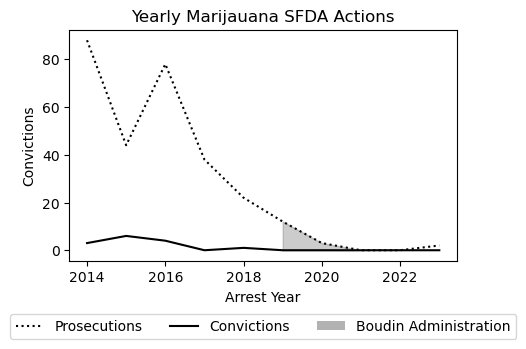

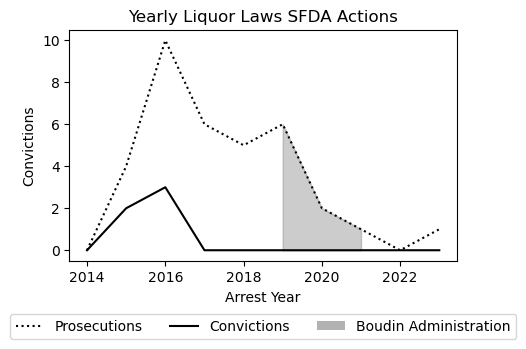

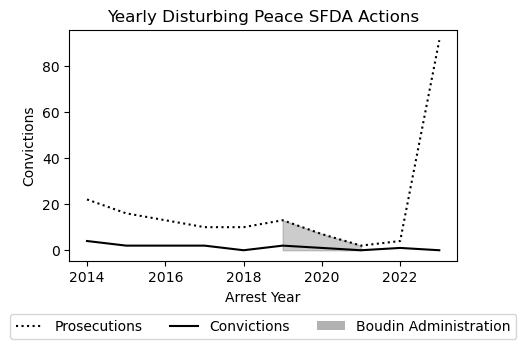

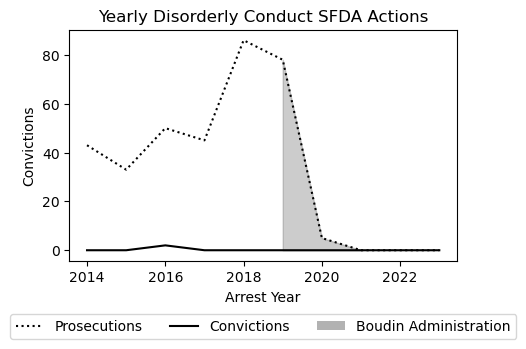

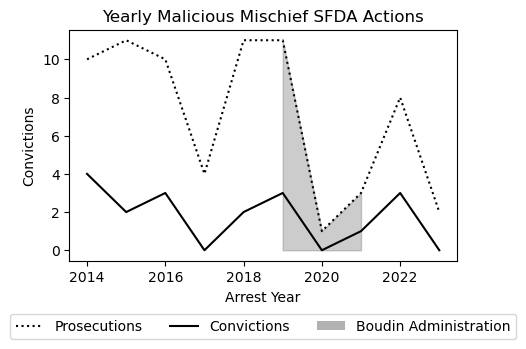

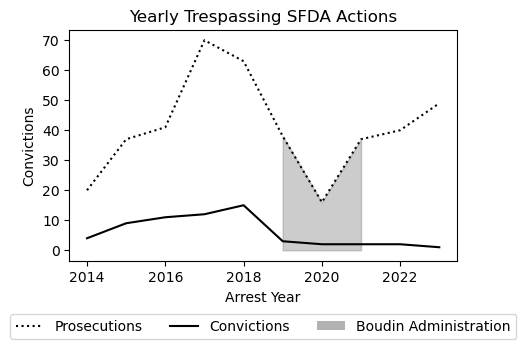

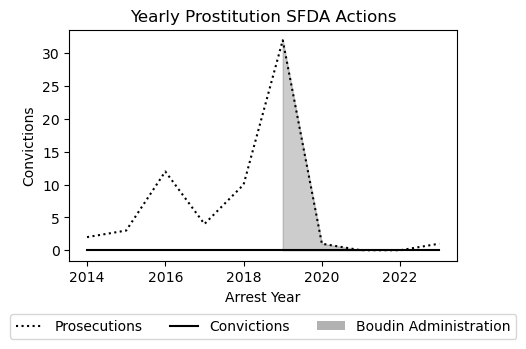

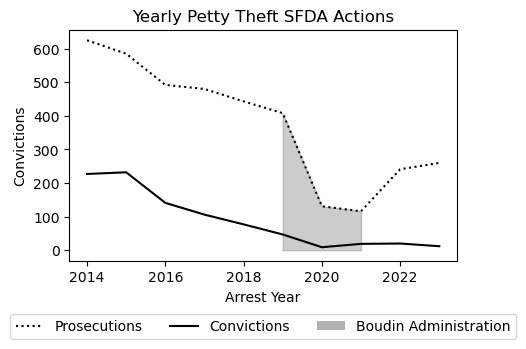

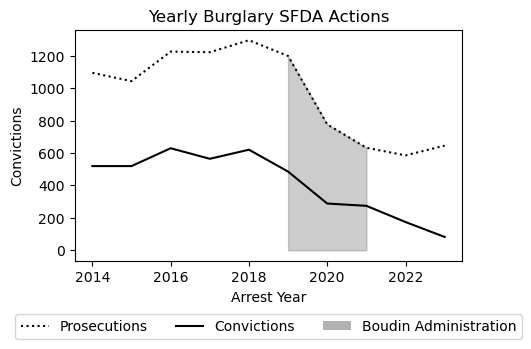

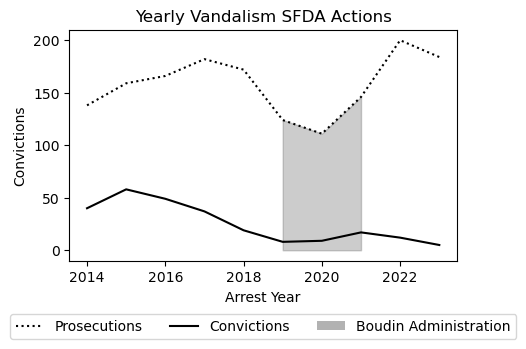

In [146]:
desired_case_status = 'Conviction'
desired_cols = qol_crimes

df1 = sfp_rev[sfp_rev['da_action_taken'] == 'New charges filed']
df2 = df1.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')
df3 = df2.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
df3 = df3.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)
df3 = df3.groupby('arrest_yr').agg(np.sum)
charges_df = df3.copy()

df1 = sfp_rev[sfp_rev['case_status'] == desired_case_status]
df2 = df1.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')
df3 = df2.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
df3 = df3.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)
df3 = df3.groupby('arrest_yr').agg(np.sum)

# Recall Boudin == 1 between (arrest_yr: 2019, arrest_month: 3) & (arrest_yr: 2021, arrest_month: 9)].
shade_start = 2019
shade_end = 2021

for col in desired_cols:
    df4 = pd.DataFrame(df3.index)
    df4.set_index('arrest_yr', inplace=True)
    label1 = f'{col}_Charges'
    df4[label1] = charges_df[col]
    label2 = f'{col}_{desired_case_status}s'

    try:
        df4[label2] = df3[col]
    except:
        df4[label2] = 0.0 

    plt.figure(figsize=(5, 3))
    line1, = plt.plot(df4.index, df4[label1], color = 'black', linestyle='dotted', label='Prosecutions')
    line2, = plt.plot(df4.index, df4[label2], color = 'black', linestyle='solid', label=f'{desired_case_status}s')
    # Adding labels and legend
    plt.title(f'Yearly {col} SFDA Actions')
    plt.xlabel('Arrest Year')
    plt.ylabel(f'{desired_case_status}s')
    plt.fill_between(df4.index, 0, df4[label1], 
                     where=(df4.index >= shade_start) & (df4.index <= shade_end), 
                     color='gray', alpha=0.4)
    
    legend_elements = [line1, line2, Patch(facecolor='gray', alpha=0.6, label='Boudin Administration')]
    
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    plt.grid(False)
    plt.show()

Marijauana


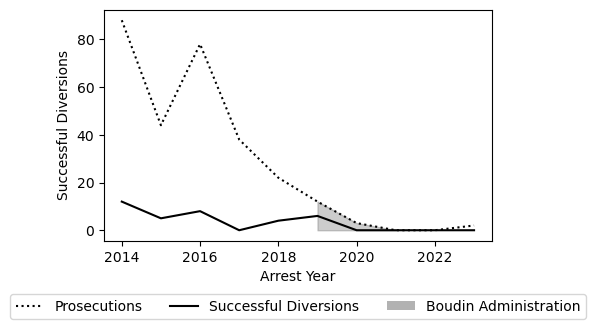

Liquor Laws


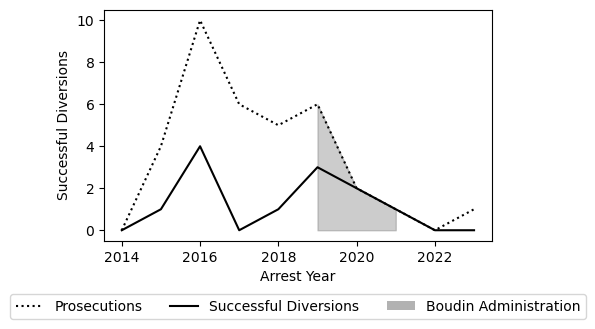

Disturbing Peace


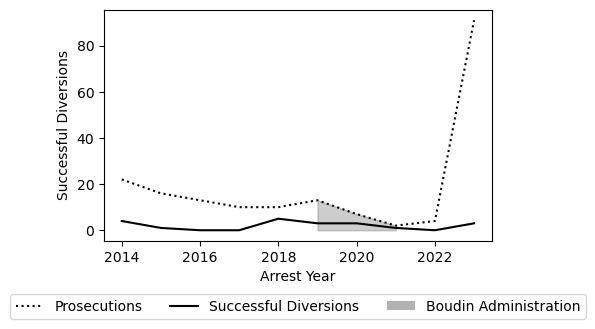

Disorderly Conduct


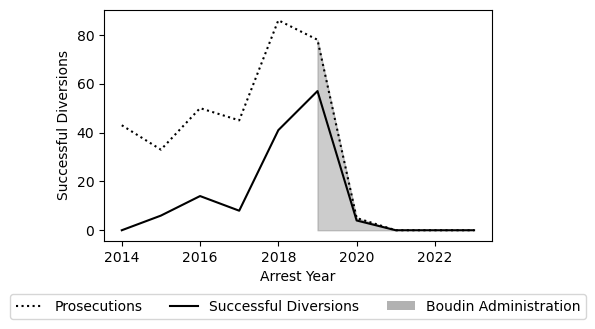

Malicious Mischief


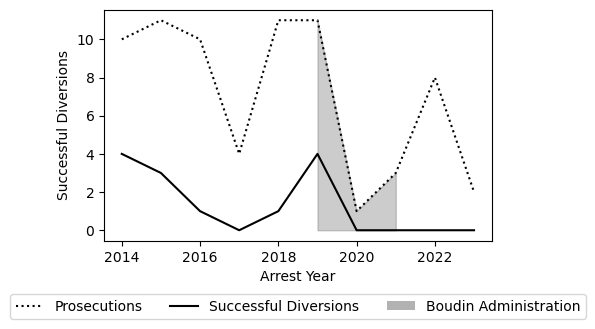

Trespassing


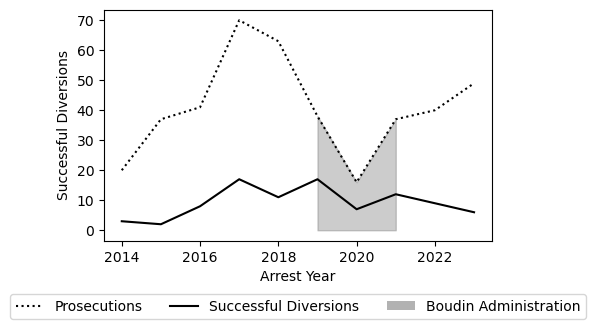

Prostitution


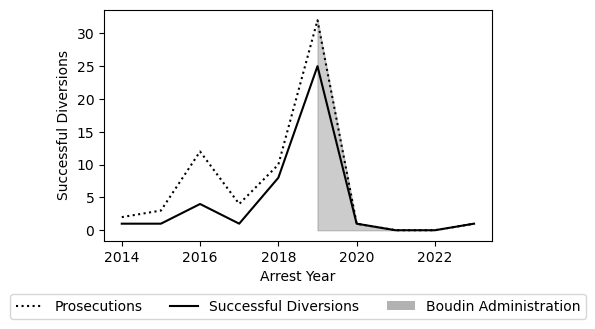

Petty Theft


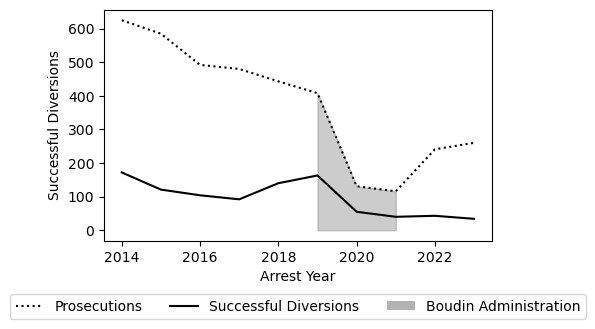

Burglary


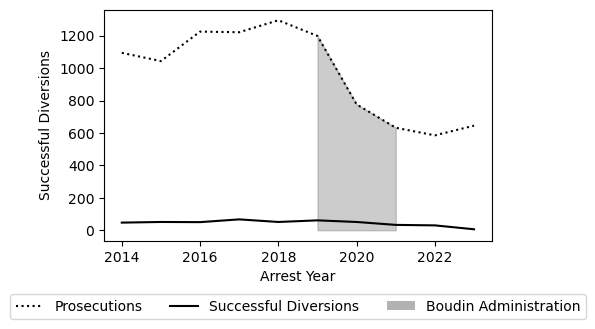

Vandalism


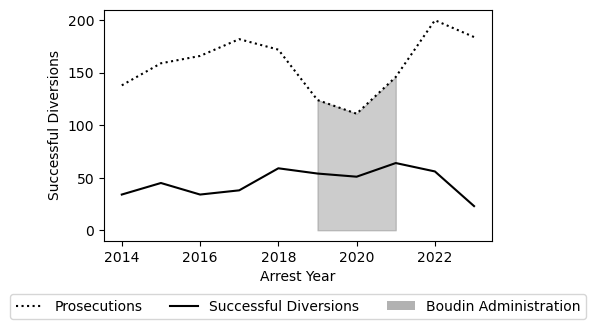

In [147]:
desired_case_status = 'Successful Diversion'
desired_cols = qol_crimes

df1 = sfp_rev[sfp_rev['da_action_taken'] == 'New charges filed']
df2 = df1.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')
df3 = df2.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
df3 = df3.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)
df3 = df3.groupby('arrest_yr').agg(np.sum)
charges_df = df3.copy()

df1 = sfp_rev[sfp_rev['case_status'] == desired_case_status]
df2 = df1.groupby(['arrest_yr', 'arrest_month', 'crime_type']).size().reset_index(name='count')
df3 = df2.pivot(index=['arrest_yr', 'arrest_month'], columns='crime_type', values='count').reset_index()
df3 = df3.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)
df3 = df3.groupby('arrest_yr').agg(np.sum)

# Recall Boudin == 1 between (arrest_yr: 2019, arrest_month: 3) & (arrest_yr: 2021, arrest_month: 9)].
shade_start = 2019
shade_end = 2021

for col in desired_cols:
    df4 = pd.DataFrame(df3.index)
    df4.set_index('arrest_yr', inplace=True)
    label1 = f'{col}_Charges'
    df4[label1] = charges_df[col]
    label2 = f'{col}_{desired_case_status}s'

    try:
        df4[label2] = df3[col]
    except:
        df4[label2] = 0.0 

    plt.figure(figsize=(5, 3))
    line1, = plt.plot(df4.index, df4[label1], color = 'black', linestyle='dotted', label='Prosecutions')
    line2, = plt.plot(df4.index, df4[label2], color = 'black', linestyle='solid', label=f'{desired_case_status}s')
    # Adding labels and legend
    # plt.title(f'Yearly {col} SFDA Actions')
    print(col)
    plt.xlabel('Arrest Year')
    plt.ylabel(f'{desired_case_status}s')
    plt.fill_between(df4.index, 0, df4[label1], 
                     where=(df4.index >= shade_start) & (df4.index <= shade_end), 
                     color='gray', alpha=0.4)
    
    legend_elements = [line1, line2, Patch(facecolor='gray', alpha=0.6, label='Boudin Administration')]
    
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    plt.grid(False)
    plt.show()

In [148]:
sfp_rev_no_qol = sfp_rev[~(sfp_rev['crime_type'].isin(qol_crimes))].reset_index()

sfp_rev_no_qol['arrest_yr'] = sfp_rev_no_qol['arrest_date'].dt.year
sfp_rev_no_qol['arrest_month'] = sfp_rev_no_qol['arrest_date'].dt.month

sfp_rev_no_qol.groupby(['arrest_yr', 'arrest_month', 'case_status', 'crime_type']).size().reset_index(name='count')

# Group by year, month, and action_type, then calculate counts
case_status_counts_no_qol = sfp_rev_no_qol.groupby(['arrest_yr', 'arrest_month', 'case_status']).size().reset_index(name='count')

case_status_pivot_no_qol = case_status_counts_no_qol.pivot(index=['arrest_yr', 'arrest_month'], columns='case_status', values='count').reset_index()
case_status_pivot_no_qol = case_status_pivot_no_qol.fillna(0).reset_index(drop=True).rename_axis(None, axis=1)
case_status_pivot_no_qol['Log_Conviction'] = np.log(case_status_pivot_no_qol['Conviction'])
case_status_pivot_no_qol['Log_Successful_Diversion'] = np.log(case_status_pivot_no_qol['Successful Diversion'])
case_status_pivot_no_qol['arrest_month_str'] = case_status_pivot_no_qol['arrest_month'].astype(str)

condition_1 = (case_status_pivot_no_qol['arrest_yr'] >= 2019) & (case_status_pivot_no_qol['arrest_yr'] <= 2021)
condition_2 = (case_status_pivot_no_qol['arrest_yr'] == 2019) & (case_status_pivot_no_qol['arrest_month'] < 3)
condition_3 = (case_status_pivot_no_qol['arrest_yr'] == 2021) & (case_status_pivot_no_qol['arrest_month'] > 9)
case_status_pivot_no_qol['Boudin'] = 0
case_status_pivot_no_qol.loc[condition_1 & ~condition_2 & ~condition_3, 'Boudin'] = 1

condition_1 = case_status_pivot_no_qol['arrest_yr'] >= 2020
condition_2 = (case_status_pivot_no_qol['arrest_yr'] == 2020) & (case_status_pivot_no_qol['arrest_month'] < 3)
case_status_pivot_no_qol['Covid_1'] = 1
case_status_pivot_no_qol.loc[condition_1 & condition_2, 'Covid_1'] = 0

condition_1 = (case_status_pivot_no_qol['arrest_yr'] >= 2020) & (case_status_pivot_no_qol['arrest_yr'] <= 2021)
case_status_pivot_no_qol['Covid_2'] = condition_1.astype(int)
case_status_pivot_no_qol.loc[condition_1 & condition_2, 'Covid_2'] = 0

case_status_pivot_no_qol_no23 = case_status_pivot_no_qol[~(case_status_pivot_no_qol['arrest_yr'] == 2023)]

In [149]:
# Placeholder
prosecutions_no_qol = sfp_rev_no_qol.groupby(['arrest_yr', 'arrest_month', 'da_action_taken']).size().reset_index(name='Prosecutions')
prosecutions_no_qol = prosecutions_no_qol[prosecutions_no_qol['da_action_taken'] == 'New charges filed']
prosecutions_no_qol['Log_Prosecutions'] = np.log(prosecutions_no_qol['Prosecutions'])

prosecutions_no_qol['arrest_month_str'] = prosecutions_no_qol['arrest_month'].astype(str)

condition_1 = (prosecutions_no_qol['arrest_yr'] >= 2020) & (prosecutions_no_qol['arrest_yr'] <= 2022)
condition_2 = (prosecutions_no_qol['arrest_yr'] == 2022) & (prosecutions_no_qol['arrest_month'] > 7)
prosecutions_no_qol['Boudin'] = 0
prosecutions_no_qol.loc[condition_1 & ~condition_2, 'Boudin'] = 1


condition_1 = prosecutions['arrest_yr'] >= 2020
condition_2 = (prosecutions_no_qol['arrest_yr'] == 2020) & (prosecutions_no_qol['arrest_month'] < 3)
prosecutions_no_qol['Covid_1'] = 1
prosecutions_no_qol.loc[condition_1 & condition_2, 'Covid_1'] = 0

condition_1 = (prosecutions_no_qol['arrest_yr'] >= 2020) & (prosecutions_no_qol['arrest_yr'] <= 2021)
prosecutions_no_qol['Covid_2'] = condition_1.astype(int)
prosecutions_no_qol.loc[condition_1 & condition_2, 'Covid_2'] = 0

prosecutions_no_qol_no23 = prosecutions_no_qol[~(prosecutions_no_qol['arrest_yr'] == 2023)]

### With 2023 Included (Log_Conviction)

#### Using Covid_1

In [150]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.088
Model:                            GLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                     3.102
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           0.000619
Time:                        19:44:00   Log-Likelihood:                -126.45
No. Observations:                 120   AIC:                             280.9
Df Residuals:                     106   BIC:                             319.9
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

#### Using Covid_2

In [151]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.148
Model:                            GLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     8.267
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.87e-11
Time:                        19:44:00   Log-Likelihood:                -122.41
No. Observations:                 120   AIC:                             272.8
Df Residuals:                     106   BIC:                             311.8
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### Without 2023 Included (Log_Conviction)

#### Using Covid_1

In [152]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.337
Model:                            GLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     13.38
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           3.27e-16
Time:                        19:44:00   Log-Likelihood:                -53.874
No. Observations:                 108   AIC:                             135.7
Df Residuals:                      94   BIC:                             173.3
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

#### Using Covid_2

In [153]:
np.random.seed(29)
formula = "Log_Conviction ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:         Log_Conviction   R-squared:                       0.533
Model:                            GLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     28.02
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.06e-26
Time:                        19:44:00   Log-Likelihood:                -34.877
No. Observations:                 108   AIC:                             97.75
Df Residuals:                      94   BIC:                             135.3
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### With 2023 Included (Log_Successful_Diversion)

#### Using Covid_1

In [154]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.347
Model:                                  GLS   Adj. R-squared:                  0.267
Method:                       Least Squares   F-statistic:                     27.78
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           2.67e-28
Time:                              19:44:00   Log-Likelihood:                -98.599
No. Observations:                       120   AIC:                             225.2
Df Residuals:                           106   BIC:                             264.2
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

#### Using Covid_2

In [155]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.347
Model:                                  GLS   Adj. R-squared:                  0.267
Method:                       Least Squares   F-statistic:                     12.89
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           1.58e-16
Time:                              19:44:00   Log-Likelihood:                -98.559
No. Observations:                       120   AIC:                             225.1
Df Residuals:                           106   BIC:                             264.1
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### Without 2023 Included (Log_Successful_Diversion)

#### Using Covid_1

In [156]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.513
Model:                                  GLS   Adj. R-squared:                  0.445
Method:                       Least Squares   F-statistic:                     32.32
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           5.49e-29
Time:                              19:44:00   Log-Likelihood:                -30.817
No. Observations:                       108   AIC:                             89.63
Df Residuals:                            94   BIC:                             127.2
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

#### Using Covid_2

In [157]:
np.random.seed(29)
formula = "Log_Successful_Diversion ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=case_status_pivot_no_qol_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                               GLS Regression Results                               
Dep. Variable:     Log_Successful_Diversion   R-squared:                       0.513
Model:                                  GLS   Adj. R-squared:                  0.446
Method:                       Least Squares   F-statistic:                     15.68
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):           2.99e-18
Time:                              19:44:00   Log-Likelihood:                -30.809
No. Observations:                       108   AIC:                             89.62
Df Residuals:                            94   BIC:                             127.2
Df Model:                                13                                         
Covariance Type:                        HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### With 2023 Included (Log_Prosecutions)

#### Using Covid_1

In [158]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.619
Model:                            GLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     22.13
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.71e-24
Time:                        19:44:00   Log-Likelihood:                 80.119
No. Observations:                 120   AIC:                            -132.2
Df Residuals:                     106   BIC:                            -93.21
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

#### Using Covid_2

In [159]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions_no_qol)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.603
Model:                            GLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     20.59
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.43e-23
Time:                        19:44:00   Log-Likelihood:                 77.741
No. Observations:                 120   AIC:                            -127.5
Df Residuals:                     106   BIC:                            -88.46
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

### Without 2023 Included (Log_Prosecutions)

#### Using Covid_1

In [160]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_1"
model = smf.gls(formula=formula, data=prosecutions_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.883
Model:                            GLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     66.64
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.65e-41
Time:                        19:44:00   Log-Likelihood:                 119.90
No. Observations:                 108   AIC:                            -211.8
Df Residuals:                      94   BIC:                            -174.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

#### Using Covid_2

In [161]:
np.random.seed(29)
formula = "Log_Prosecutions ~ Boudin + arrest_month_str + Covid_2"
model = smf.gls(formula=formula, data=prosecutions_no23)
result = model.fit(cov_type='HC0')
print(result.summary())

                            GLS Regression Results                            
Dep. Variable:       Log_Prosecutions   R-squared:                       0.787
Model:                            GLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     41.82
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           2.78e-33
Time:                        19:44:01   Log-Likelihood:                 87.309
No. Observations:                 108   AIC:                            -146.6
Df Residuals:                      94   BIC:                            -109.1
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

## Stage III - SF Crime Analysis

In [162]:
url = "https://data.sfgov.org/resource/wg3w-h783.json"
desired_year = 2023

params = {
    '$limit' : 500000000,
    'incident_year' : desired_year
}


response = requests.get(url, params=params)

if response.status_code == 200:
    # The API request was successful
    data = response.json()
    
    # Create a DataFrame from the JSON data
    df = pd.DataFrame(data)
    
    # Now 'df' contains the data in a DataFrame format
    df.head(5)
else:
    # The API request failed
    print(f"Error: {response.status_code}")
    print(response.text)

In [163]:
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])
df['incident_month'] = df['incident_datetime'].dt.month

In [164]:
incident_counts = df[['analysis_neighborhood', 'incident_category']].value_counts().reset_index()
intersection_coords = df[['intersection', 'longitude', 'latitude']]
intersection_coords = intersection_coords[~df['intersection'].isna()].reset_index(drop=True).drop_duplicates()
intersection_coords.loc[:, 'longitude'] = intersection_coords['longitude'].astype(float)
intersection_coords.loc[:, 'latitude'] = intersection_coords['latitude'].astype(float)

# incident_hotspots = incident_counts[incident_counts['count'] > 10]
# incident_hotspots = incident_hotspots.merge(intersection_coords, left_on = 'intersection',
#                                            right_on = 'intersection', how='inner')

In [165]:
incident_counts = df.groupby(['analysis_neighborhood', 'incident_category']).size().reset_index(name='count')

all_combinations = pd.MultiIndex.from_product([df['analysis_neighborhood'].unique(), 
                                               df['incident_category'].unique()], 
                                              names=['analysis_neighborhood', 'incident_category'])

incident_counts = incident_counts.set_index(['analysis_neighborhood', 'incident_category']).reindex(all_combinations, fill_value=0).reset_index()

incident_counts['count'] = incident_counts['count'].astype(int)

incident_counts = incident_counts.dropna().reset_index(drop=True)

In [166]:
dummy = incident_counts.copy()

dummy = dummy.groupby('incident_category').agg({'count' : np.sum}).reset_index()

dummy['Year'] = desired_year

dummy = dummy[['Year', 'incident_category', 'count']]

csv_file_path = './incident_counts_by_crime_master.csv'

### This is for if the csv_already exists
try:
    ic_master = pd.read_csv(csv_file_path)
    df_combined = pd.concat([ic_master, dummy], ignore_index=True).drop_duplicates()
    df_combined.to_csv(csv_file_path, index=False, mode='w')

### This is for if the csv_already needs to be created (i.e. Need to creater the csv)
except:
    dummy.to_csv(csv_file_path, index=False, mode='w')

In [167]:
violent_crimes = ['Assault', 'Robbery', 'Offences Against The Family And Children', 
                  'Weapons Carrying Etc', 'Weapons Offense', 'Arson', 'Sex Offense', 
                  'Human Trafficking (A), Commercial Sex Acts', 'Rape', 'Homicide', 
                  'Weapons Offence', 'Human Trafficking, Commercial Sex Acts',
                  'Human Trafficking (B), Involuntary Servitude']

incident_counts_a = incident_counts.groupby('analysis_neighborhood').agg({'count' : np.sum})

incident_counts_a['Year'] = desired_year

incident_counts_v = incident_counts[incident_counts['incident_category'].isin(violent_crimes)]
incident_counts_v = incident_counts_v.groupby('analysis_neighborhood').agg({'count' : np.sum})

incident_counts_v['Year'] = desired_year

In [168]:
qol_crimes = ['Drug Offense', 'Liquor Laws', 'Disorderly Conduct', 'Malicious Mischief',
                  'Prostitution', 'Larceny Theft', 'Burglary', 'Vandalism', 'Civil Sidewalks', 'Non-Criminal']

### I will use these dfs to load the data into my csv's
ica_for_csv = df[['incident_year', 'incident_month', 'incident_category']]
ica_for_csv = ica_for_csv[['incident_year', 'incident_month', 'incident_category']].value_counts().reset_index()
ica_for_csv = ica_for_csv.sort_values(['incident_month', 'incident_category']).reset_index(drop = True)

icv_for_csv = ica_for_csv[ica_for_csv['incident_category'].isin(violent_crimes)].reset_index(drop = True)

ic_noqol_for_csv = ica_for_csv[~(ica_for_csv['incident_category'].isin(qol_crimes))].reset_index(drop = True)
ic_noqol_for_csv

,incident_year,incident_month,incident_category,count
0,2023,1,Arson,32
1,2023,1,Assault,694
2,2023,1,Case Closure,41
3,2023,1,Courtesy Report,28
4,2023,1,Drug Violation,2
...,...,...,...,...
399,2023,12,Vehicle Impounded,13
400,2023,12,Vehicle Misplaced,3
401,2023,12,Warrant,302
402,2023,12,Weapons Carrying Etc,57


In [169]:
ic_df_dict = {'./ica_by_month_master.csv' : ica_for_csv,
             './icv_by_month_master.csv' : icv_for_csv,
             './ic_noqol_by_month_master.csv' : ic_noqol_for_csv}

for path in ic_df_dict.keys():    
    dummy = ic_df_dict[path]

    csv_file_path = path

    ### This is for if the csv_already exists
    try:
        ic_master = pd.read_csv(csv_file_path)
        df_combined = pd.concat([ic_master, dummy], ignore_index=True)
        df_combined.to_csv(csv_file_path, index=False, mode='w')

    ### This is for if the csv_already needs to be created (i.e. Need to create the csv)
    except:
        dummy.to_csv(csv_file_path, index=False, mode='w')

In [170]:
url = "https://data.sfgov.org/resource/j2bu-swwd.json"

response = requests.get(url)

if response.status_code == 200:
    # The API request was successful
    data = response.json()
    
    # Create a DataFrame from the JSON data
    geo_df = pd.DataFrame(data)
    
    # Now 'df' contains the data in a DataFrame format
    geo_df.head(5)
else:
    # The API request failed
    print(f"Error: {response.status_code}")
    print(response.text)

In [171]:
geo_df['geometry'] = geo_df['the_geom'].apply(lambda x: shape(x))

gdf = gpd.GeoDataFrame(geo_df, geometry='geometry')

# sf_center = {"lat": 37.7749, "lon": -122.4194} True Center
sf_center = {"lat": 37.7709, "lon": -122.4364} # For plotting purposes

gdf = gdf.merge(incident_counts_a, left_on = 'nhood', right_on = 'analysis_neighborhood', how='inner')

gdf = gdf.set_index('nhood')

scale_max = 20000

midpoint = scale_max / 2

### Comment out when not using because it takes a lot of memory
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf.geometry.__geo_interface__,
#     locations=gdf.index,
#     color='count',
#     color_continuous_scale="gray_r",
#     color_continuous_midpoint=midpoint,
#     mapbox_style="carto-positron",
#     center=sf_center,
#     zoom=10.75,
#     width = 600,
#     height = 590
# )

# # title = f'CRIME INCIDENT COUNTS {desired_year} (BY NEIGHBORHOOD)'
# # fig.update_layout(
# #     title_text=title,
# #     title_x=0.5,
# #     title_font=dict(family="Timess New Roman", size=18, color="black"),
# # )

# fig.update_layout(
#     coloraxis_colorbar=dict(
#         title={'text': 'Incidents', 'font': {'color': 'black', 'size' : 12}}
#     )
# )

# print(desired_year)
# # # Remove the color scale bar and legend
# # fig.update_layout(coloraxis_showscale=False)


# fig.show()

In [172]:
dummy = gdf[['Year', 'count']].reset_index()

dummy = dummy[['Year', 'nhood', 'count']]

csv_file_path = './incident_counts_a_master.csv'

### This is for if the csv_already exists
try:
    ic_master = pd.read_csv(csv_file_path)
    df_combined = pd.concat([ic_master, dummy], ignore_index=True).drop_duplicates()
    df_combined.to_csv(csv_file_path, index=False, mode='w')

### This is for if the csv_already needs to be created (i.e. Need to creater the csv)
except:
    dummy.to_csv(csv_file_path, index=False, mode='w')

In [173]:
geo_df['geometry'] = geo_df['the_geom'].apply(lambda x: shape(x))

gdf = gpd.GeoDataFrame(geo_df, geometry='geometry')

# sf_center = {"lat": 37.7749, "lon": -122.4194} True Center
sf_center = {"lat": 37.7709, "lon": -122.4364} # For plotting purposes

gdf = gdf.merge(incident_counts_v, left_on = 'nhood', right_on = 'analysis_neighborhood', how='inner')

gdf = gdf.set_index('nhood')

scale_max = 3000

midpoint = scale_max / 2

### Comment out when not using because it takes a lot of memory
# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf.geometry.__geo_interface__,
#     locations=gdf.index,
#     color='count',
#     color_continuous_scale="gray_r",
#     color_continuous_midpoint=midpoint,
#     mapbox_style="carto-positron",
#     center=sf_center,
#     zoom=10.75,
#     width = 600,
#     height = 590
# )

# # title = f'VIOLENT CRIME INCIDENT COUNTS {desired_year} (BY NEIGHBORHOOD)'
# # fig.update_layout(
# #     title_text=title,
# #     title_x=0.5,
# #     title_font=dict(family="Timess New Roman", size=18, color="black"),
# # )

# fig.update_layout(
#     coloraxis_colorbar=dict(
#         title={'text': 'Incidents', 'font': {'color': 'black', 'size' : 12}}
#     )
# )

# print(desired_year)
# # # Remove the color scale bar and legend
# # fig.update_layout(coloraxis_showscale=False)

# fig.show()

In [174]:
dummy = gdf[['Year', 'count']].reset_index()

dummy = dummy[['Year', 'nhood', 'count']]

csv_file_path = './incident_counts_v_master.csv'

### This is for if the csv_already exists
try:
    ic_master = pd.read_csv(csv_file_path)
    df_combined = pd.concat([ic_master, dummy], ignore_index=True)
    df_combined.to_csv(csv_file_path, index=False, mode='w')

### This is for if the csv_already needs to be created (i.e. Need to creater the csv)
except:
    dummy.to_csv(csv_file_path, index=False, mode='w')

In [175]:
desired_crimes = ['Drug Offense', 'Liquor Laws', 'Disorderly Conduct', 'Malicious Mischief',
                  'Prostitution', 'Larceny Theft', 'Burglary', 'Vandalism', 'Civil Sidewalks', 'Non-Criminal']

In [176]:
### Comment out when not using because it takes a lot of memory
# for desired_crime in desired_crimes:
#     geo_df['geometry'] = geo_df['the_geom'].apply(lambda x: shape(x))

#     gdf = gpd.GeoDataFrame(geo_df, geometry='geometry')

#     # sf_center = {"lat": 37.7749, "lon": -122.4194} True Center
#     sf_center = {"lat": 37.7709, "lon": -122.4364} # For plotting purposes

#     gdf = gdf.merge(incident_counts, left_on = 'nhood', right_on = 'analysis_neighborhood', how='inner')

#     gdf = gdf[gdf['incident_category'] == desired_crime]

#     gdf = gdf.set_index('nhood')

#     fig = px.choropleth_mapbox(
#         gdf,
#         geojson=gdf.geometry.__geo_interface__,
#         locations=gdf.index,
#         color='count',
#         color_continuous_scale="gray_r",
#         mapbox_style="carto-positron",
#         center=sf_center,
#         zoom=10.6,
#         width = 600,
#         height = 590
#     )

#     title = f'{desired_crime.upper()} INCIDENT COUNTS {desired_year} (BY NEIGHBORHOOD)'
#     fig.update_layout(
#         title_text=title,
#         title_x=0.5,
#         title_font=dict(family="Timess New Roman", size=18, color="black"),
#     )

#     fig.update_layout(
#         coloraxis_colorbar=dict(
#             title={'text': 'Incident Count', 'font': {'color': 'black', 'size' : 12}}
#         )
#     )

#     fig.show()

In [177]:
### Comment out when not using because it takes a lot of memory
# gdf['Zero_col'] = 0 #Use for graphing

# fig = px.choropleth_mapbox(
#     gdf,
#     geojson=gdf.geometry.__geo_interface__,
#     locations=gdf.index,
#     color='Zero_col',
#     color_continuous_scale="RdBu",
#     mapbox_style="carto-positron",
#     center=sf_center,
#     zoom=10.7,
#     width = 600,
#     height = 600
# )

# title = 'ONLY USE TO MAKE MAP OF THE NEIGHBORHOODS MANUALLY'
# fig.update_layout(
#     title_text=title,
#     title_x=0.5,
#     title_font=dict(family="Timess New Roman", size=18, color="black"),
# )
    
# fig.show()

Yearly Incidents (2018-2023)


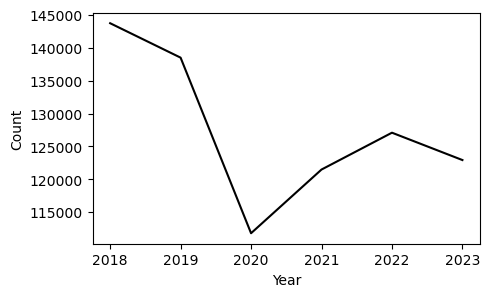

In [178]:
csv_file_path = './incident_counts_a_master.csv'
ic_master = pd.read_csv(csv_file_path)
ic_master = ic_master.groupby('Year').agg({'count': np.sum})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Year', y='count', data=ic_master, color='black', linestyle = 'solid', errorbar=None)

print(f'Yearly Incidents (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

Yearly Incidents (2018-2023)


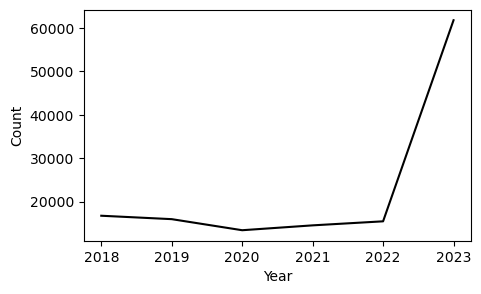

In [60]:
csv_file_path = './incident_counts_v_master.csv'
ic_master = pd.read_csv(csv_file_path)
ic_master = ic_master.groupby('Year').agg({'count': np.sum})

plt.figure(figsize=(5, 3))
sns.lineplot(x='Year', y='count', data=ic_master, color='black', linestyle = 'solid', errorbar=None)

print(f'Yearly Incidents (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

Yearly Drug Offense Incidents (2018-2023)


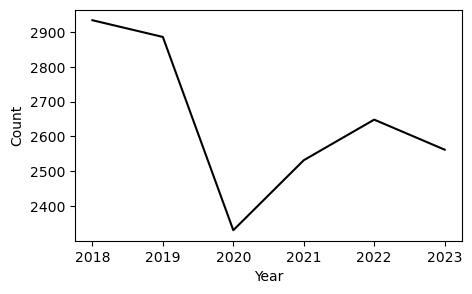

Yearly Liquor Laws Incidents (2018-2023)


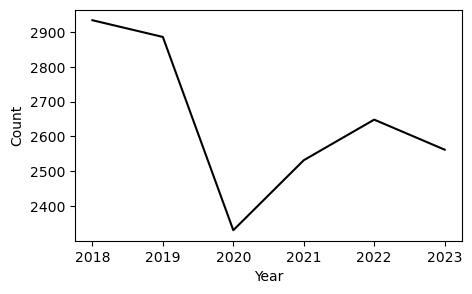

Yearly Disorderly Conduct Incidents (2018-2023)


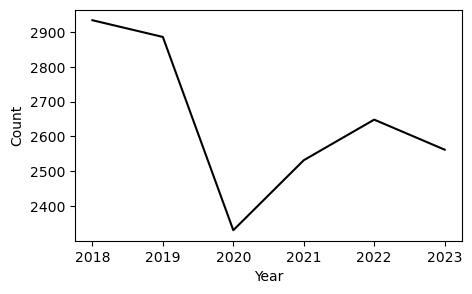

Yearly Malicious Mischief Incidents (2018-2023)


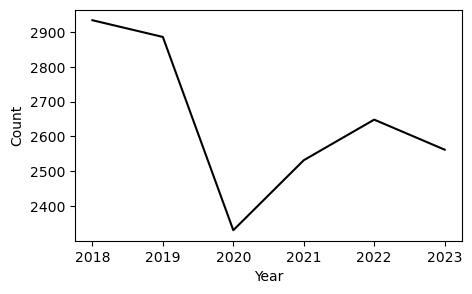

Yearly Prostitution Incidents (2018-2023)


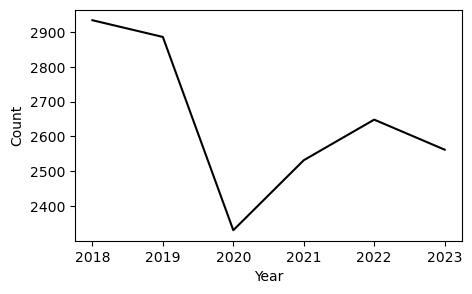

Yearly Larceny Theft Incidents (2018-2023)


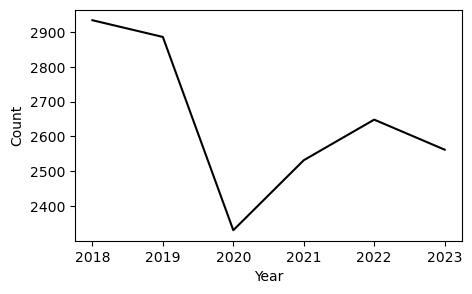

Yearly Burglary Incidents (2018-2023)


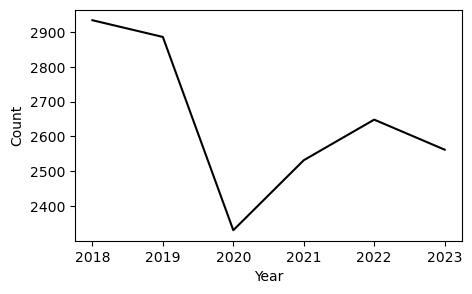

Yearly Vandalism Incidents (2018-2023)


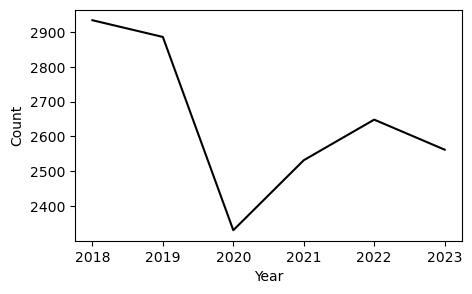

Yearly Civil Sidewalks Incidents (2018-2023)


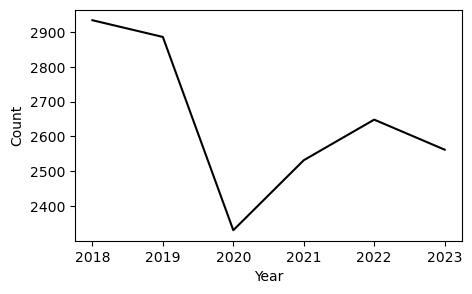

Yearly Non-Criminal Incidents (2018-2023)


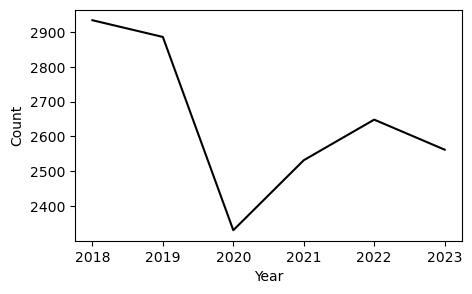

In [180]:
csv_file_path = './incident_counts_by_crime_master.csv'
ic_master = pd.read_csv(csv_file_path)


for desired_crime in desired_crimes:
    plot_df = ic_master[ic_master['incident_category'] == desired_crime]
    plt.figure(figsize=(5, 3))
    sns.lineplot(x='Year', y='count', data=ic_master, color='black', linestyle = 'solid', errorbar=None)

    print(f'Yearly {desired_crime} Incidents (2018-2023)')
    plt.xlabel('Year')
    plt.ylabel('Count')

    plt.show()

### Model
<br></br>
$Y_{m, t} = \beta_0 + \beta_1 (\widehat{\textit{Log Prosecutions}_{m, t}}) + \mu_{m} + \pi_{m, t} + \epsilon_{m, t}$
<br></br>
$\widehat{\textit{Log Prosecutions}_{m, t}} = \beta_0 + \beta_1 Boudin_{m, t} + \mu_{m} + \pi_{m, t} + \eta_{m, t}$

- $Y_{m, t} \text{ = Dependent Variable in month m during year t}$
- $\textit{Log Prosecutions}_{m, t} \text{ = Log_Prosecutions in month m during year t}$
- $Boudin_{m, t} \text{ = Binary Indicator for whether Chesa Boudin was in office in month m during year t} \rightarrow$ **<ins>Instrumental Variable</ins>**
- $\mu_{m} \text{ = Monthly Fixed-Effects}$
- $\pi_{m, t} \text{ = COVID Pandemic Fixed-Effect; Either } COVID_1 \text{ or } COVID_2$
- $COVID_1 \text{ = COVID using simple cuttoff at the start of the CA Shelter-In-Place-Orders, March 2020}$
- $COVID_2 \text{ = COVID using a range from March 2020 to the end of 2021, when the virus became endemic}$

In [96]:
csv_file_path = './ica_by_month_master.csv'
ic_a = pd.read_csv(csv_file_path).drop_duplicates()

csv_file_path = './icv_by_month_master.csv'
ic_v = pd.read_csv(csv_file_path).drop_duplicates()

csv_file_path = './ic_noqol_by_month_master.csv'
ic_noqol = pd.read_csv(csv_file_path).drop_duplicates()

display(ic_a, ic_v, ic_noqol)

,incident_year,incident_month,incident_category,count
0,2018,1,Arson,26
1,2018,1,Assault,715
2,2018,1,Burglary,614
3,2018,1,Case Closure,50
4,2018,1,Civil Sidewalks,24
...,...,...,...,...
3110,2023,12,Vehicle Impounded,13
3111,2023,12,Vehicle Misplaced,3
3112,2023,12,Warrant,302
3113,2023,12,Weapons Carrying Etc,57


,incident_year,incident_month,incident_category,count
0,2018,1,Arson,26
1,2018,1,Assault,715
2,2018,1,Homicide,1
3,2018,1,"Human Trafficking (A), Commercial Sex Acts",1
4,2018,1,Offences Against The Family And Children,142
...,...,...,...,...
688,2023,12,Rape,2
689,2023,12,Robbery,249
690,2023,12,Sex Offense,6
691,2023,12,Weapons Carrying Etc,57


,incident_year,incident_month,incident_category,count
0,2018,1,Arson,26
1,2018,1,Assault,715
2,2018,1,Case Closure,50
3,2018,1,Courtesy Report,32
4,2018,1,Drug Violation,3
...,...,...,...,...
2452,2023,12,Vehicle Impounded,13
2453,2023,12,Vehicle Misplaced,3
2454,2023,12,Warrant,302
2455,2023,12,Weapons Carrying Etc,57


Yearly Incidents (2018-2023)


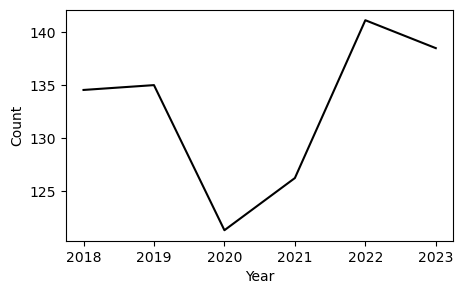

In [97]:
ic_master = ic_v.drop_duplicates()
ic_master #= ic_master.groupby('incident_year').agg({'count': np.sum})
len(ic_master[ic_master['incident_year'] == 2023])


plt.figure(figsize=(5, 3))
sns.lineplot(x='incident_year', y='count', data=ic_master, color='black', linestyle = 'solid', errorbar=None)

print(f'Yearly Incidents (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

In [98]:
ic_a_yr_tots = ic_a.groupby(['incident_year', 'incident_month']).agg({'count':np.sum}).rename(columns={'count' : 'Incident_Tots'}).reset_index()
ic_v_yr_tots = ic_v.groupby(['incident_year', 'incident_month']).agg({'count':np.sum}).rename(columns={'count' : 'Incident_Tots'}).reset_index()
ic_noqol_yr_tots = ic_noqol.groupby(['incident_year', 'incident_month']).agg({'count':np.sum}).rename(columns={'count' : 'Incident_Tots'}).reset_index()

In [99]:
### For ic_a_yr_tots
ic_a_yr_tots['incident_month_str'] = ic_a_yr_tots['incident_month'].astype(str)

condition_1 = (ic_a_yr_tots['incident_year'] >= 2020) & (ic_a_yr_tots['incident_year'] <= 2022)
condition_2 = (ic_a_yr_tots['incident_year'] == 2022) & (ic_a_yr_tots['incident_month'] > 7)
ic_a_yr_tots['Boudin'] = 0
ic_a_yr_tots.loc[condition_1 & ~condition_2, 'Boudin'] = 1


condition_1 = ic_a_yr_tots['incident_year'] >= 2020
condition_2 = (ic_a_yr_tots['incident_year'] == 2020) & (ic_a_yr_tots['incident_month'] < 3)
ic_a_yr_tots['Covid_1'] = 1
ic_a_yr_tots.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (ic_a_yr_tots['incident_year'] >= 2020) & (ic_a_yr_tots['incident_year'] <= 2021)
ic_a_yr_tots['Covid_2'] = condition_1.astype(int)
ic_a_yr_tots.loc[condition_1 & condition_2, 'Covid_2'] = 0

### For ic_v_yr_tots
ic_v_yr_tots['incident_month_str'] = ic_v_yr_tots['incident_month'].astype(str)


condition_1 = (ic_v_yr_tots['incident_year'] >= 2020) & (ic_v_yr_tots['incident_year'] <= 2022)
condition_2 = (ic_v_yr_tots['incident_year'] == 2022) & (ic_v_yr_tots['incident_month'] > 7)
ic_v_yr_tots['Boudin'] = 0
ic_v_yr_tots.loc[condition_1 & ~condition_2, 'Boudin'] = 1


condition_1 = ic_v_yr_tots['incident_year'] >= 2020
condition_2 = (ic_v_yr_tots['incident_year'] == 2020) & (ic_a_yr_tots['incident_month'] < 3)
ic_v_yr_tots['Covid_1'] = 1
ic_v_yr_tots.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (ic_v_yr_tots['incident_year'] >= 2020) & (ic_v_yr_tots['incident_year'] <= 2021)
ic_v_yr_tots['Covid_2'] = condition_1.astype(int)
ic_v_yr_tots.loc[condition_1 & condition_2, 'Covid_2'] = 0

### For ic_noqol_yr_tots
ic_noqol_yr_tots['incident_month_str'] = ic_noqol_yr_tots['incident_month'].astype(str)


condition_1 = (ic_noqol_yr_tots['incident_year'] >= 2020) & (ic_noqol_yr_tots['incident_year'] <= 2022)
condition_2 = (ic_noqol_yr_tots['incident_year'] == 2022) & (ic_noqol_yr_tots['incident_month'] > 7)
ic_noqol_yr_tots['Boudin'] = 0
ic_noqol_yr_tots.loc[condition_1 & ~condition_2, 'Boudin'] = 1


condition_1 = ic_noqol_yr_tots['incident_year'] >= 2020
condition_2 = (ic_noqol_yr_tots['incident_year'] == 2020) & (ic_noqol_yr_tots['incident_month'] < 3)
ic_noqol_yr_tots['Covid_1'] = 1
ic_noqol_yr_tots.loc[~condition_1 | condition_2, 'Covid_1'] = 0

condition_1 = (ic_noqol_yr_tots['incident_year'] >= 2020) & (ic_noqol_yr_tots['incident_year'] <= 2021)
ic_noqol_yr_tots['Covid_2'] = condition_1.astype(int)
ic_noqol_yr_tots.loc[condition_1 & condition_2, 'Covid_2'] = 0

In [100]:
ic_a_yr_tots['Log_Incident_Tots'] = np.log(ic_a_yr_tots['Incident_Tots'])
ic_v_yr_tots['Log_Incident_Tots'] = np.log(ic_v_yr_tots['Incident_Tots'])
ic_noqol_yr_tots['Log_Incident_Tots'] = np.log(ic_noqol_yr_tots['Incident_Tots'])

ic_a_yr_tots['Log_Prosecutions'] = prosecutions[prosecutions['arrest_yr'] >= 2018].reset_index()['Log_Prosecutions']
ic_v_yr_tots['Log_Prosecutions'] = prosecutions[prosecutions['arrest_yr'] >= 2018].reset_index()['Log_Prosecutions']
ic_noqol_yr_tots['Log_Prosecutions'] = prosecutions[prosecutions['arrest_yr'] >= 2018].reset_index()['Log_Prosecutions']

In [101]:
ic_a_yr_tots_no23 = ic_a_yr_tots[ic_a_yr_tots['incident_year'] < 2023]
ic_v_yr_tots_no23 = ic_a_yr_tots[ic_a_yr_tots['incident_year'] < 2023]
ic_noqol_yr_tots_no23 = ic_a_yr_tots[ic_a_yr_tots['incident_year'] < 2023]

## Standard 2SLS

In [102]:
def standard_2sls(data, covid_col):
    first_stage_formula = f'Log_Prosecutions ~ Boudin + incident_month_str + {covid_col}'
    first_stage_model = IV2SLS.from_formula(first_stage_formula, data)
    first_stage_results = first_stage_model.fit(cov_type='kernel') # Same as HC0 covariance matrix
    print('First Stage Results:')
    print(first_stage_results)

    data['Log_Prosecutions_hat'] = first_stage_results.predict()

    second_stage_formula = f'Log_Incident_Tots ~ Log_Prosecutions_hat + incident_month_str + {covid_col}'
    second_stage_model = IV2SLS.from_formula(second_stage_formula, data)
    second_stage_results = second_stage_model.fit(cov_type='kernel')
    
    print('\n\nSecond Stage Results:')
    print(second_stage_results)

### With 2023 Included (All Crimes)

#### Using Covid_1

In [103]:
standard_2sls(ic_a_yr_tots, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9004
Estimator:                        OLS   Adj. R-squared:                 0.8781
No. Observations:                  72   F-statistic:                    849.22
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:55:12   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5795     0.0274     240.27     0.0000

#### Using Covid_2

In [104]:
standard_2sls(ic_a_yr_tots, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.5680
Estimator:                        OLS   Adj. R-squared:                 0.4712
No. Observations:                  72   F-statistic:                    67.835
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:55:28   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.4679     0.1074     60.205     0.0000

### Without 2023 Included (All Crimes)

#### Using Covid_1

In [105]:
standard_2sls(ic_a_yr_tots_no23, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9221
Estimator:                        OLS   Adj. R-squared:                 0.9001
No. Observations:                  60   F-statistic:                    1017.8
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:55:40   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5916     0.0270     244.34     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


#### Using Covid_2

In [106]:
standard_2sls(ic_a_yr_tots_no23, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.7709
Estimator:                        OLS   Adj. R-squared:                 0.7062
No. Observations:                  60   F-statistic:                    386.65
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:55:51   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5960     0.0497     132.74     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


### With 2023 Included (Violent Crimes)

#### Using Covid_1

In [107]:
standard_2sls(ic_v_yr_tots, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9004
Estimator:                        OLS   Adj. R-squared:                 0.8781
No. Observations:                  72   F-statistic:                    849.22
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:55:53   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5795     0.0274     240.27     0.0000

#### Using Covid_2

In [108]:
standard_2sls(ic_v_yr_tots, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.5680
Estimator:                        OLS   Adj. R-squared:                 0.4712
No. Observations:                  72   F-statistic:                    67.835
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:05   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.4679     0.1074     60.205     0.0000

### Without 2023 Included (Violent Crimes)

#### Using Covid_1

In [109]:
standard_2sls(ic_v_yr_tots_no23, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9221
Estimator:                        OLS   Adj. R-squared:                 0.9001
No. Observations:                  60   F-statistic:                    1017.8
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:05   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5916     0.0270     244.34     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


#### Using Covid_2

In [110]:
standard_2sls(ic_v_yr_tots_no23, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.7709
Estimator:                        OLS   Adj. R-squared:                 0.7062
No. Observations:                  60   F-statistic:                    386.65
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:06   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5960     0.0497     132.74     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


### With 2023 Included (No QOL Crimes)

#### Using Covid_1

In [111]:
standard_2sls(ic_noqol_yr_tots, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9004
Estimator:                        OLS   Adj. R-squared:                 0.8781
No. Observations:                  72   F-statistic:                    849.22
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:08   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5795     0.0274     240.27     0.0000

#### Using Covid_2

In [112]:
standard_2sls(ic_noqol_yr_tots, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.5680
Estimator:                        OLS   Adj. R-squared:                 0.4712
No. Observations:                  72   F-statistic:                    67.835
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:08   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.4679     0.1074     60.205     0.0000

### Without 2023 Included (No QOL Crimes)

#### Using Covid_1

In [113]:
standard_2sls(ic_noqol_yr_tots_no23, 'Covid_1')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.9221
Estimator:                        OLS   Adj. R-squared:                 0.9001
No. Observations:                  60   F-statistic:                    1017.8
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:09   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5916     0.0270     244.34     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


#### Using Covid_2

In [114]:
standard_2sls(ic_noqol_yr_tots_no23, 'Covid_2')

First Stage Results:
                            OLS Estimation Summary                            
Dep. Variable:       Log_Prosecutions   R-squared:                      0.7709
Estimator:                        OLS   Adj. R-squared:                 0.7062
No. Observations:                  60   F-statistic:                    386.65
Date:                Thu, Jan 25 2024   P-value (F-stat)                0.0000
Time:                        15:56:12   Distribution:                 chi2(13)
Cov. Estimator:                kernel                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    6.5960     0.0497     132.74     0.0000

C:\Users\jgte2\AppData\Local\Temp\ipykernel_1132\612090827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Prosecutions_hat'] = first_stage_results.predict()


## 2SLS with Neural Network for First-Stage Equation

### With 2023 Included (All Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (All Crimes)

#### Using Covid_1

#### Using Covid_2

### With 2023 Included (Violent Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (Violent Crimes)

#### Using Covid_1

#### Using Covid_2

### With 2023 Included (No QOL Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (No QOL Crimes)

#### Using Covid_1

#### Using Covid_2

## 2SLS with KNN for First-Stage Equation

### With 2023 Included (All Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (All Crimes)

#### Using Covid_1

#### Using Covid_2

### With 2023 Included (Violent Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (Violent Crimes)

#### Using Covid_1

#### Using Covid_2

### With 2023 Included (No QOL Crimes)

#### Using Covid_1

#### Using Covid_2

### Without 2023 Included (No QOL Crimes)

#### Using Covid_1

#### Using Covid_2